# Class For DecisionTree

In [5]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


class CardioDecisionTreeClassifier:
    """
    A reusable Decision Tree classifier for cardiovascular disease prediction.
    
    Features:
    - Train/test split with customizable ratio
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, test_size=0.2, random_state=42, max_depth=None,
                 min_samples_split=2, min_samples_leaf=1, scale_features=True,
                 target_col='cardio', drop_cols=None):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        test_size : float, default=0.2
            Proportion of dataset to include in test split
        random_state : int, default=42
            Random state for reproducibility
        max_depth : int, default=None
            Maximum depth of the tree
        min_samples_split : int, default=2
            Minimum samples required to split a node
        min_samples_leaf : int, default=1
            Minimum samples required at a leaf node
        scale_features : bool, default=True
            Whether to scale features
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        """
        
        self.test_size = test_size
        self.random_state = random_state
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.scale_features = scale_features
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else []
        
        self.model = None
        self.scaler = None
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        self.metrics = {}
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self):
        """
        Preprocess the data for training.
        Uses `self.target_col` and `self.drop_cols` from initialization.
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        df = self.data.copy()
        if self.drop_cols:
            df = df.drop(columns=self.drop_cols, errors='ignore')
        
        X = df.drop(columns=[self.target_col])
        y = df[self.target_col]
        
        self.feature_names = X.columns.tolist()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
            self.X_test = pd.DataFrame(
                self.scaler.transform(self.X_test),
                columns=self.feature_names,
                index=self.X_test.index
            )
        
        print(f"Data preprocessed: Train size = {len(self.X_train)}, Test size = {len(self.X_test)}")
    
    def train(self):
        """Train the Decision Tree classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        self.model = DecisionTreeClassifier(
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            random_state=self.random_state,
            splitter='best',
            criterion='gini'
        )
        
        self.model.fit(self.X_train, self.y_train)
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses test set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        if X is None:
            X_to_predict = self.X_test
        else:
            X_to_predict = X

        if X is not None and self.scale_features and self.scaler is not None:
            X_to_predict = pd.DataFrame(
                self.scaler.transform(X_to_predict),
                columns=X_to_predict.columns,
                index=X_to_predict.index
            )
        
        return self.model.predict(X_to_predict)
    
    def evaluate(self):
        """
        Evaluate model performance on test set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        y_pred = self.predict()
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, average='binary'),
            'recall': recall_score(self.y_test, y_pred, average='binary'),
            'f1_score': f1_score(self.y_test, y_pred, average='binary'),
            'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision: {self.metrics['precision']:.4f}")
        print(f"Recall:    {self.metrics['recall']:.4f}")
        print(f"F1-Score:  {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(self.metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                      target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions for the *entire* loaded dataset to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        
        # Prepare the full dataset for prediction
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
            
        X_full = X_full.drop(columns=[self.target_col], errors='ignore')
        
        # Ensure columns match training data
        X_full = X_full[self.feature_names]
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.model.predict(X_full_scaled)
        else:
            predictions = self.model.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df[self.target_col] = self.data[self.target_col]
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, include_all_data=True):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        include_all_data : bool, default=True
            Passed to export_predictions to control output file content.
            
        Returns:
        --------
        dict : Performance metrics
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data()
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath, include_all_data=include_all_data)
        
        print("Pipeline completed successfully!")
        return metrics


# Example usage
if __name__ == "__main__":
    # Configure the model with all parameters during initialization
    clf = CardioDecisionTreeClassifier(
        test_size=0.20,
        random_state=42,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        scale_features=True,
        target_col='cardio',  # <--- Parameter moved here
        drop_cols=['id']      # <--- Parameter moved here
    )
    
    # Run the pipeline with just the filepaths
    matrix_decisiontree = clf.run_full_pipeline(
        input_filepath='train.csv',
        output_filepath='cardio_train_pred.csv'
    )


Starting full pipeline...

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7307
Precision: 0.7588
Recall:    0.6673
F1-Score:  0.7101

Confusion Matrix:
[[5492 1437]
 [2254 4521]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.71      0.79      0.75      6929
     Disease       0.76      0.67      0.71      6775

    accuracy                           0.73     13704
   macro avg       0.73      0.73      0.73     13704
weighted avg       0.73      0.73      0.73     13704


Predictions exported to: cardio_train_pred.csv
Pipeline completed successfully!


# Logistic Regression


In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


class CardioLogisticRegressionClassifier:
    """
    A reusable Logistic Regression classifier for cardiovascular disease prediction.
    
    Features:
    - Train/test split with customizable ratio
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, test_size=0.2, random_state=42, C=1.0, 
                 solver='lbfgs', max_iter=100, scale_features=True,
                 target_col='cardio', drop_cols=None):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        test_size : float, default=0.2
            Proportion of dataset to include in test split
        random_state : int, default=42
            Random state for reproducibility
        C : float, default=1.0
            Inverse of regularization strength; smaller values specify stronger regularization
        solver : str, default='lbfgs'
            Algorithm to use in the optimization problem
        max_iter : int, default=100
            Maximum number of iterations taken for the solvers to converge
        scale_features : bool, default=True
            Whether to scale features
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        """

        self.test_size = test_size
        self.random_state = random_state
        self.C = C
        self.solver = solver
        self.max_iter = max_iter
        self.scale_features = scale_features
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else []
        
        self.model = None
        self.scaler = None
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        self.metrics = {}
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self):
        """
        Preprocess the data for training.
        Uses `self.target_col` and `self.drop_cols` from initialization.
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        df = self.data.copy()
        if self.drop_cols:
            df = df.drop(columns=self.drop_cols, errors='ignore')
        
        X = df.drop(columns=[self.target_col])
        y = df[self.target_col]
        
        self.feature_names = X.columns.tolist()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
            self.X_test = pd.DataFrame(
                self.scaler.transform(self.X_test),
                columns=self.feature_names,
                index=self.X_test.index
            )
        
        print(f"Data preprocessed: Train size = {len(self.X_train)}, Test size = {len(self.X_test)}")
    
    def train(self):
        """Train the Logistic Regression classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        self.model = LogisticRegression(
            C=self.C,
            solver=self.solver,
            max_iter=self.max_iter,
            random_state=self.random_state,
            penalty='l2'
        )
        
        self.model.fit(self.X_train, self.y_train)
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses test set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        if X is None:
            X_to_predict = self.X_test
        else:
            X_to_predict = X

        if X is not None and self.scale_features and self.scaler is not None:
            # When predicting on new, external data
            X_to_predict = pd.DataFrame(
                self.scaler.transform(X_to_predict),
                columns=X_to_predict.columns,
                index=X_to_predict.index
            )
        
        return self.model.predict(X_to_predict)
    
    def evaluate(self):
        """
        Evaluate model performance on test set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        y_pred = self.predict()
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, average='binary'),
            'recall': recall_score(self.y_test, y_pred, average='binary'),
            'f1_score': f1_score(self.y_test, y_pred, average='binary'),
            'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision: {self.metrics['precision']:.4f}")
        print(f"Recall:    {self.metrics['recall']:.4f}")
        print(f"F1-Score:  {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(self.metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                      target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions for the *entire* loaded dataset to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        
        # Prepare the full dataset for prediction
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
            
        X_full = X_full.drop(columns=[self.target_col], errors='ignore')
        
        # Ensure columns match training data
        X_full = X_full[self.feature_names]
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.model.predict(X_full_scaled)
        else:
            predictions = self.model.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df[self.target_col] = self.data[self.target_col]
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, include_all_data=True):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        include_all_data : bool, default=True
            Passed to export_predictions to control output file content.
            
        Returns:
        --------
        dict : Performance metrics
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data()
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath, include_all_data=include_all_data)
        
        print("Pipeline completed successfully!")
        return metrics


# Example usage
if __name__ == "__main__":
    # Configure the model with all parameters during initialization
    clf = CardioLogisticRegressionClassifier(
        test_size=0.2,
        random_state=12,
        C=1,
        solver='newton-cg',
        max_iter=2000, # Increased max_iter for convergence
        scale_features=True,
        target_col='cardio',  # <--- Parameter moved here
        drop_cols=['id']      # <--- Parameter moved here
    )
    
    # Run the pipeline with just the filepaths
    matrix_logisticregression = clf.run_full_pipeline(
        input_filepath='train.csv',
        output_filepath='Prediction_LogisticRegression.csv' # Changed output name
    )
    print(matrix_logisticregression)


Starting full pipeline...

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7251
Precision: 0.7510
Recall:    0.6642
F1-Score:  0.7049

Confusion Matrix:
[[5437 1492]
 [2275 4500]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.71      0.78      0.74      6929
     Disease       0.75      0.66      0.70      6775

    accuracy                           0.73     13704
   macro avg       0.73      0.72      0.72     13704
weighted avg       0.73      0.73      0.72     13704


Predictions exported to: Prediction_LogisticRegression.csv
Pipeline completed successfully!
{'accuracy': 0.7251167542323409, 'precision': 0.7510013351134847, 'recall': 0.6642066420664207, 'f1_score': 0.7049424297015744, 'confusion_matrix': array([[5437, 1492],
       [2275, 4500]])}


# Random Forest


In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


class CardioRandomForestClassifier:
    """
    A reusable Random Forest classifier for cardiovascular disease prediction.
    
    Features:
    - Train/test split with customizable ratio
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, test_size=0.2, random_state=42, n_estimators=100, 
                 max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                 scale_features=True, target_col='cardio', drop_cols=None):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        test_size : float, default=0.2
            Proportion of dataset to include in test split
        random_state : int, default=42
            Random state for reproducibility
        n_estimators : int, default=100
            Number of trees in the forest
        max_depth : int, default=None
            Maximum depth of the tree
        min_samples_split : int, default=2
            Minimum samples required to split a node
        min_samples_leaf : int, default=1
            Minimum samples required at a leaf node
        scale_features : bool, default=True
            Whether to scale features
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        """

        self.test_size = test_size
        self.random_state = random_state
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.scale_features = scale_features
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else []
        
        self.model = None
        self.scaler = None
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        self.metrics = {}
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self):
        """
        Preprocess the data for training.
        Uses `self.target_col` and `self.drop_cols` from initialization.
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        df = self.data.copy()
        if self.drop_cols:
            df = df.drop(columns=self.drop_cols, errors='ignore')
        
        X = df.drop(columns=[self.target_col])
        y = df[self.target_col]
        
        self.feature_names = X.columns.tolist()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
            self.X_test = pd.DataFrame(
                self.scaler.transform(self.X_test),
                columns=self.feature_names,
                index=self.X_test.index
            )
        
        print(f"Data preprocessed: Train size = {len(self.X_train)}, Test size = {len(self.X_test)}")
    
    def train(self):
        """Train the Random Forest classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        self.model = RandomForestClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            random_state=self.random_state
        )
        
        self.model.fit(self.X_train, self.y_train)
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses test set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        if X is None:
            X_to_predict = self.X_test
        else:
            X_to_predict = X

        if X is not None and self.scale_features and self.scaler is not None:
            # When predicting on new, external data
            X_to_predict = pd.DataFrame(
                self.scaler.transform(X_to_predict),
                columns=X_to_predict.columns,
                index=X_to_predict.index
            )
        
        return self.model.predict(X_to_predict)
    
    def evaluate(self):
        """
        Evaluate model performance on test set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        y_pred = self.predict()
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, average='binary'),
            'recall': recall_score(self.y_test, y_pred, average='binary'),
            'f1_score': f1_score(self.y_test, y_pred, average='binary'),
            'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision: {self.metrics['precision']:.4f}")
        print(f"Recall:    {self.metrics['recall']:.4f}")
        print(f"F1-Score:  {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(self.metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                      target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions for the *entire* loaded dataset to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        
        # Prepare the full dataset for prediction
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
            
        X_full = X_full.drop(columns=[self.target_col], errors='ignore')
        
        # Ensure columns match training data
        X_full = X_full[self.feature_names]
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.model.predict(X_full_scaled)
        else:
            predictions = self.model.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df[self.target_col] = self.data[self.target_col]
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, include_all_data=True):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        include_all_data : bool, default=True
            Passed to export_predictions to control output file content.
            
        Returns:
        --------
        dict : Performance metrics
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data()
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath, include_all_data=include_all_data)
        
        print("Pipeline completed successfully!")
        return metrics


# Example usage
if __name__ == "__main__":
    # Configure the model with all parameters during initialization
    clf = CardioRandomForestClassifier(
        test_size=0.2,
        random_state=42,
        n_estimators=100,
        max_depth=1000,
        min_samples_split=20,
        min_samples_leaf=10,
        scale_features=True,
        target_col='cardio',  # <--- Parameter moved here
        drop_cols=['id']      # <--- Parameter moved here
    )
    
    # Run the pipeline with just the filepaths
    matrix_randomforest = clf.run_full_pipeline(
        input_filepath='train.csv',
        output_filepath='Prediction_RandomForest.csv' # Changed output name
    )


Starting full pipeline...

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7299
Precision: 0.7464
Recall:    0.6869
F1-Score:  0.7154

Confusion Matrix:
[[5348 1581]
 [2121 4654]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.72      0.77      0.74      6929
     Disease       0.75      0.69      0.72      6775

    accuracy                           0.73     13704
   macro avg       0.73      0.73      0.73     13704
weighted avg       0.73      0.73      0.73     13704


Predictions exported to: Prediction_RandomForest.csv
Pipeline completed successfully!


# Naive Base


In [8]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


class CardioNaiveBayesClassifier:
    """
    A reusable Naive Bayes classifier for cardiovascular disease prediction.
    
    Features:
    - Train/test split with customizable ratio
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, test_size=0.2, random_state=42, var_smoothing=1e-9, 
                 scale_features=True, target_col='cardio', drop_cols=None):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        test_size : float, default=0.2
            Proportion of dataset to include in test split
        random_state : int, default=42
            Random state for reproducibility
        var_smoothing : float, default=1e-9
            Portion of the largest variance of all features that is added to variances for calculation stability
        scale_features : bool, default=True
            Whether to scale features
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        """

        self.test_size = test_size
        self.random_state = random_state
        self.var_smoothing = var_smoothing
        self.scale_features = scale_features
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else []
        
        self.model = None
        self.scaler = None
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        self.metrics = {}
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self):
        """
        Preprocess the data for training.
        Uses `self.target_col` and `self.drop_cols` from initialization.
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        df = self.data.copy()
        if self.drop_cols:
            df = df.drop(columns=self.drop_cols, errors='ignore')
        
        X = df.drop(columns=[self.target_col])
        y = df[self.target_col]
        
        self.feature_names = X.columns.tolist()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
            self.X_test = pd.DataFrame(
                self.scaler.transform(self.X_test),
                columns=self.feature_names,
                index=self.X_test.index
            )
        
        print(f"Data preprocessed: Train size = {len(self.X_train)}, Test size = {len(self.X_test)}")
    
    def train(self):
        """Train the Naive Bayes classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        self.model = GaussianNB(
            var_smoothing=self.var_smoothing
        )
        
        self.model.fit(self.X_train, self.y_train)
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses test set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        if X is None:
            X_to_predict = self.X_test
        else:
            X_to_predict = X

        if X is not None and self.scale_features and self.scaler is not None:
            # When predicting on new, external data
            X_to_predict = pd.DataFrame(
                self.scaler.transform(X_to_predict),
                columns=X_to_predict.columns,
                index=X_to_predict.index
            )
        
        return self.model.predict(X_to_predict)
    
    def evaluate(self):
        """
        Evaluate model performance on test set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        y_pred = self.predict()
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, average='binary'),
            'recall': recall_score(self.y_test, y_pred, average='binary'),
            'f1_score': f1_score(self.y_test, y_pred, average='binary'),
            'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision: {self.metrics['precision']:.4f}")
        print(f"Recall:    {self.metrics['recall']:.4f}")
        print(f"F1-Score:  {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(self.metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                      target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions for the *entire* loaded dataset to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        
        # Prepare the full dataset for prediction
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
            
        X_full = X_full.drop(columns=[self.target_col], errors='ignore')
        
        # Ensure columns match training data
        X_full = X_full[self.feature_names]
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.model.predict(X_full_scaled)
        else:
            predictions = self.model.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df[self.target_col] = self.data[self.target_col]
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, include_all_data=True):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        include_all_data : bool, default=True
            Passed to export_predictions to control output file content.
            
        Returns:
        --------
        dict : Performance metrics
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data()
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath, include_all_data=include_all_data)
        
        print("Pipeline completed successfully!")
        return metrics


# Example usage
if __name__ == "__main__":
    # Configure the model with all parameters during initialization
    clf = CardioNaiveBayesClassifier(
        test_size=0.2,
        random_state=42,
        var_smoothing=1e-9,
        scale_features=True,
        target_col='cardio',  # <--- Parameter moved here
        drop_cols=['id']      # <--- Parameter moved here
    )
    
    # Run the pipeline with just the filepaths
    matrix_naivebayes = clf.run_full_pipeline(
        input_filepath='train.csv',
        output_filepath='Prediction_NaiveBayes.csv' # Changed output name
    )


Starting full pipeline...

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7072
Precision: 0.7501
Recall:    0.6114
F1-Score:  0.6737

Confusion Matrix:
[[5549 1380]
 [2633 4142]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.68      0.80      0.73      6929
     Disease       0.75      0.61      0.67      6775

    accuracy                           0.71     13704
   macro avg       0.71      0.71      0.70     13704
weighted avg       0.71      0.71      0.70     13704


Predictions exported to: Prediction_NaiveBayes.csv
Pipeline completed successfully!


# Gradient Boosting


In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


class CardioGradientBoostingClassifier:
    """
    A reusable Gradient Boosting classifier for cardiovascular disease prediction.
    
    Features:
    - Train/test split with customizable ratio
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, test_size=0.2, random_state=42, n_estimators=100, 
                 learning_rate=0.1, max_depth=3, scale_features=True,
                 target_col='cardio', drop_cols=None):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        test_size : float, default=0.2
            Proportion of dataset to include in test split
        random_state : int, default=42
            Random state for reproducibility
        n_estimators : int, default=100
            The number of boosting stages to perform
        learning_rate : float, default=0.1
            Learning rate shrinks the contribution of each tree by learning_rate
        max_depth : int, default=3
            Maximum depth of the individual regression estimators
        scale_features : bool, default=True
            Whether to scale features
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        """

        self.test_size = test_size
        self.random_state = random_state
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.scale_features = scale_features
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else []
        
        self.model = None
        self.scaler = None
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        self.metrics = {}
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self):
        """
        Preprocess the data for training.
        Uses `self.target_col` and `self.drop_cols` from initialization.
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        df = self.data.copy()
        if self.drop_cols:
            df = df.drop(columns=self.drop_cols, errors='ignore')
        
        X = df.drop(columns=[self.target_col])
        y = df[self.target_col]
        
        self.feature_names = X.columns.tolist()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
            self.X_test = pd.DataFrame(
                self.scaler.transform(self.X_test),
                columns=self.feature_names,
                index=self.X_test.index
            )
        
        print(f"Data preprocessed: Train size = {len(self.X_train)}, Test size = {len(self.X_test)}")
    
    def train(self):
        """Train the Gradient Boosting classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        self.model = GradientBoostingClassifier(
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            max_depth=self.max_depth,
            random_state=self.random_state
        )
        
        self.model.fit(self.X_train, self.y_train)
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses test set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        if X is None:
            X_to_predict = self.X_test
        else:
            X_to_predict = X

        if X is not None and self.scale_features and self.scaler is not None:
            # When predicting on new, external data
            X_to_predict = pd.DataFrame(
                self.scaler.transform(X_to_predict),
                columns=X_to_predict.columns,
                index=X_to_predict.index
            )
        
        return self.model.predict(X_to_predict)
    
    def evaluate(self):
        """
        Evaluate model performance on test set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        y_pred = self.predict()
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, average='binary'),
            'recall': recall_score(self.y_test, y_pred, average='binary'),
            'f1_score': f1_score(self.y_test, y_pred, average='binary'),
            'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision: {self.metrics['precision']:.4f}")
        print(f"Recall:    {self.metrics['recall']:.4f}")
        print(f"F1-Score:  {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(self.metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                      target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions for the *entire* loaded dataset to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        
        # Prepare the full dataset for prediction
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
            
        X_full = X_full.drop(columns=[self.target_col], errors='ignore')
        
        # Ensure columns match training data
        X_full = X_full[self.feature_names]
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.model.predict(X_full_scaled)
        else:
            predictions = self.model.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df[self.target_col] = self.data[self.target_col]
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, include_all_data=True):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        include_all_data : bool, default=True
            Passed to export_predictions to control output file content.
            
        Returns:
        --------
        dict : Performance metrics
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data()
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath, include_all_data=include_all_data)
        
        print("Pipeline completed successfully!")
        return metrics


# Example usage
if __name__ == "__main__":
    # Configure the model with all parameters during initialization
    clf = CardioGradientBoostingClassifier(
        test_size=0.2,
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=10,
        scale_features=True,
        target_col='cardio',  # <--- Parameter moved here
        drop_cols=['id']      # <--- Parameter moved here
    )
    
    # Run the pipeline with just the filepaths
    matrix_gradientboosting = clf.run_full_pipeline(
        input_filepath='train.csv',
        output_filepath='Prediction_GradientBoosting.csv' # Changed output name
    )


Starting full pipeline...

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7248
Precision: 0.7400
Recall:    0.6832
F1-Score:  0.7105

Confusion Matrix:
[[5303 1626]
 [2146 4629]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.71      0.77      0.74      6929
     Disease       0.74      0.68      0.71      6775

    accuracy                           0.72     13704
   macro avg       0.73      0.72      0.72     13704
weighted avg       0.73      0.72      0.72     13704


Predictions exported to: Prediction_GradientBoosting.csv
Pipeline completed successfully!


# SVM 


In [10]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


class CardioSupportVectorClassifier:
    """
    A reusable Support Vector Machine classifier for cardiovascular disease prediction.
    
    Features:
    - Train/test split with customizable ratio
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, test_size=0.2, random_state=42, C=1.0, 
                 kernel='rbf', gamma='scale', scale_features=True,
                 target_col='cardio', drop_cols=None):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        test_size : float, default=0.2
            Proportion of dataset to include in test split
        random_state : int, default=42
            Random state for reproducibility
        C : float, default=1.0
            Regularization parameter. The strength of the regularization is inversely proportional to C
        kernel : str, default='rbf'
            Specifies the kernel type to be used in the algorithm
        gamma : float or str, default='scale'
            Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
        scale_features : bool, default=True
            Whether to scale features
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        """

        self.test_size = test_size
        self.random_state = random_state
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.scale_features = scale_features
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else []
        
        self.model = None
        self.scaler = None
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        self.metrics = {}
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self):
        """
        Preprocess the data for training.
        Uses `self.target_col` and `self.drop_cols` from initialization.
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        df = self.data.copy()
        if self.drop_cols:
            df = df.drop(columns=self.drop_cols, errors='ignore')
        
        X = df.drop(columns=[self.target_col])
        y = df[self.target_col]
        
        self.feature_names = X.columns.tolist()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
            self.X_test = pd.DataFrame(
                self.scaler.transform(self.X_test),
                columns=self.feature_names,
                index=self.X_test.index
            )
        
        print(f"Data preprocessed: Train size = {len(self.X_train)}, Test size = {len(self.X_test)}")
    
    def train(self):
        """Train the Support Vector Machine classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        self.model = SVC(
            C=self.C,
            kernel=self.kernel,
            gamma=self.gamma,
            random_state=self.random_state
        )
        
        self.model.fit(self.X_train, self.y_train)
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses test set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        if X is None:
            X_to_predict = self.X_test
        else:
            X_to_predict = X

        if X is not None and self.scale_features and self.scaler is not None:
            # When predicting on new, external data
            X_to_predict = pd.DataFrame(
                self.scaler.transform(X_to_predict),
                columns=X_to_predict.columns,
                index=X_to_predict.index
            )
        
        return self.model.predict(X_to_predict)
    
    def evaluate(self):
        """
        Evaluate model performance on test set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        y_pred = self.predict()
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, average='binary'),
            'recall': recall_score(self.y_test, y_pred, average='binary'),
            'f1_score': f1_score(self.y_test, y_pred, average='binary'),
            'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision: {self.metrics['precision']:.4f}")
        print(f"Recall:    {self.metrics['recall']:.4f}")
        print(f"F1-Score:  {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(self.metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                      target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions for the *entire* loaded dataset to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        
        # Prepare the full dataset for prediction
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
            
        X_full = X_full.drop(columns=[self.target_col], errors='ignore')
        
        # Ensure columns match training data
        X_full = X_full[self.feature_names]
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.model.predict(X_full_scaled)
        else:
            predictions = self.model.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df[self.target_col] = self.data[self.target_col]
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, include_all_data=True):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        include_all_data : bool, default=True
            Passed to export_predictions to control output file content.
            
        Returns:
        --------
        dict : Performance metrics
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data()
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath, include_all_data=include_all_data)
        
        print("Pipeline completed successfully!")
        return metrics


# Example usage
if __name__ == "__main__":
    # Configure the model with all parameters during initialization
    clf = CardioSupportVectorClassifier(
        test_size=0.2,
        random_state=42,
        C=1.0,
        kernel='poly',
        gamma='scale',
        scale_features=True,
        target_col='cardio',  # <--- Parameter moved here
        drop_cols=['id']      # <--- Parameter moved here
    )
    
    # Run the pipeline with just the filepaths
    matrix_svm = clf.run_full_pipeline(
        input_filepath='train.csv',
        output_filepath='Prediction_SVM.csv' # Changed output name
    )


Starting full pipeline...

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7149
Precision: 0.7718
Recall:    0.6010
F1-Score:  0.6758

Confusion Matrix:
[[5725 1204]
 [2703 4072]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.68      0.83      0.75      6929
     Disease       0.77      0.60      0.68      6775

    accuracy                           0.71     13704
   macro avg       0.73      0.71      0.71     13704
weighted avg       0.73      0.71      0.71     13704


Predictions exported to: Prediction_SVM.csv
Pipeline completed successfully!


# KNN

In [27]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


class CardioKNeighborsClassifier:
    """
    A reusable K-Nearest Neighbors classifier for cardiovascular disease prediction.
    
    Features:
    - No train/test split (trains on full dataset)
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, n_neighbors=5, weights='uniform', metric='euclidean', 
                 scale_features=True, target_col='cardio', drop_cols=None):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        n_neighbors : int, default=5
            Number of neighbors to use by default for kneighbors queries
        weights : str, default='uniform'
            Weight function used in prediction
        metric : str, default='euclidean'
            Distance metric to use for the tree
        scale_features : bool, default=True
            Whether to scale features
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        """

        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        self.scale_features = scale_features
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else []
        
        self.model = None
        self.scaler = None
        self.data = None
        self.X_train = None
        self.y_train = None
        self.feature_names = None
        self.metrics = {}
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self):
        """
        Preprocess the data for training.
        Uses `self.target_col` and `self.drop_cols` from initialization.
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        df = self.data.copy()
        if self.drop_cols:
            df = df.drop(columns=self.drop_cols, errors='ignore')
        
        X = df.drop(columns=[self.target_col])
        y = df[self.target_col]
        
        self.feature_names = X.columns.tolist()
        
        # Use entire dataset for training (no train-test split)
        self.X_train = X
        self.y_train = y
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
        
        print(f"Data preprocessed: Training on entire dataset with {len(self.X_train)} samples")
    
    def train(self):
        """Train the K-Nearest Neighbors classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        self.model = KNeighborsClassifier(
            n_neighbors=self.n_neighbors,
            weights=self.weights,
            metric=self.metric
        )
        
        self.model.fit(self.X_train, self.y_train)
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses training set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        if X is None:
            X_to_predict = self.X_train
        else:
            X_to_predict = X

        if X is not None and self.scale_features and self.scaler is not None:
            # When predicting on new, external data
            X_to_predict = pd.DataFrame(
                self.scaler.transform(X_to_predict),
                columns=X_to_predict.columns,
                index=X_to_predict.index
            )
        
        return self.model.predict(X_to_predict)
    
    def evaluate(self):
        """
        Evaluate model performance on training set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics (without confusion matrix)
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        y_pred = self.predict()
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_train, y_pred),
            'precision': precision_score(self.y_train, y_pred, average='binary'),
            'recall': recall_score(self.y_train, y_pred, average='binary'),
            'f1_score': f1_score(self.y_train, y_pred, average='binary')
        }
        
        # Compute confusion matrix separately for display
        cm = confusion_matrix(self.y_train, y_pred)
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision: {self.metrics['precision']:.4f}")
        print(f"Recall:    {self.metrics['recall']:.4f}")
        print(f"F1-Score:  {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(cm)
        print("\nClassification Report:")
        print(classification_report(self.y_train, y_pred, 
                                      target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions for the *entire* loaded dataset to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        
        # Prepare the full dataset for prediction
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
            
        X_full = X_full.drop(columns=[self.target_col], errors='ignore')
        
        # Ensure columns match training data
        X_full = X_full[self.feature_names]
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.model.predict(X_full_scaled)
        else:
            predictions = self.model.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df[self.target_col] = self.data[self.target_col]
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, include_all_data=True):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        include_all_data : bool, default=True
            Passed to export_predictions to control output file content.
            
        Returns:
        --------
        dict : Performance metrics dictionary (accuracy, precision, recall, f1_score)
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data()
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath, include_all_data=include_all_data)
        
        print("Pipeline completed successfully!")
        return metrics


# Example usage
if __name__ == "__main__":
    # Configure the model with specified parameters
    clf = CardioKNeighborsClassifier(
        n_neighbors=3,
        weights='distance',
        metric='euclidean',
        scale_features=True,
        target_col='cardio',
        drop_cols=['id']
    )
    
    # Run the pipeline and store metrics in matrix_knn
    matrix_knn = clf.run_full_pipeline(
        input_filepath='train.csv',
        output_filepath='Prediction_KNN.csv'
    )
    
    # Display the metrics dictionary
    print("\nMetrics Dictionary (matrix_knn):")
    print(matrix_knn)


Starting full pipeline...

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Training on entire dataset with 68520 samples
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.9721
Precision: 0.9883
Recall:    0.9548
F1-Score:  0.9713

Confusion Matrix:
[[34259   384]
 [ 1530 32347]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.96      0.99      0.97     34643
     Disease       0.99      0.95      0.97     33877

    accuracy                           0.97     68520
   macro avg       0.97      0.97      0.97     68520
weighted avg       0.97      0.97      0.97     68520


Predictions exported to: Prediction_KNN.csv
Pipeline completed successfully!

Metrics Dictionary (matrix_knn):
{'accuracy': 0.9720665499124344, 'precision': 0.988268002810791, 'recall': 0.9548366148124096, 'f1_score': 0.9712647129473937}


# DL Algorithms


In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


class CardioMLPClassifier:
    """
    A reusable Multi-Layer Perceptron (MLP) deep learning classifier for cardiovascular disease prediction using PyTorch.
    
    Features:
    - Train/test split with customizable ratio
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, test_size=0.2, random_state=42, hidden_sizes=[64, 32], 
                 lr=0.001, epochs=100, batch_size=32, scale_features=True):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        test_size : float, default=0.2
            Proportion of dataset to include in test split
        random_state : int, default=42
            Random state for reproducibility
        hidden_sizes : list, default=[64, 32]
            List of hidden layer sizes
        lr : float, default=0.001
            Learning rate for the optimizer
        epochs : int, default=100
            Number of training epochs
        batch_size : int, default=32
            Batch size for training
        scale_features : bool, default=True
            Whether to scale features
        """

        self.test_size = test_size
        self.random_state = random_state
        self.hidden_sizes = hidden_sizes
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.scale_features = scale_features
        
        self.model = None
        self.scaler = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_tensor = None
        self.y_train_tensor = None
        self.feature_names = None
        self.metrics = {}
        self.drop_cols = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self, target_col='cardio', drop_cols=None):
        """
        Preprocess the data for training.
        
        Parameters:
        -----------
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        self.drop_cols = drop_cols if drop_cols else []
        
        df = self.data.copy()
        if drop_cols:
            df = df.drop(columns=drop_cols, errors='ignore')
        
        X = df.drop(columns=[target_col])
        y = df[target_col]
        
        self.feature_names = X.columns.tolist()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
            self.X_test = pd.DataFrame(
                self.scaler.transform(self.X_test),
                columns=self.feature_names,
                index=self.X_test.index
            )
        
        print(f"Data preprocessed: Train size = {len(self.X_train)}, Test size = {len(self.X_test)}")
    
    def train(self):
        """Train the MLP classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        # Convert to tensors
        X_train_tensor = torch.FloatTensor(self.X_train.values).to(self.device)
        y_train_tensor = torch.LongTensor(self.y_train.values).to(self.device)
        
        self.X_train_tensor = X_train_tensor
        self.y_train_tensor = y_train_tensor
        
        # Define model
        input_size = len(self.feature_names)
        layers = []
        prev_size = input_size
        for size in self.hidden_sizes:
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.ReLU())
            prev_size = size
        layers.append(nn.Linear(prev_size, 2))  # Binary classification
        
        self.model = nn.Sequential(*layers).to(self.device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        # DataLoader
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        self.model.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            if (epoch + 1) % 50 == 0:
                avg_loss = running_loss / len(train_loader)
                print(f'Epoch [{epoch+1}/{self.epochs}], Loss: {avg_loss:.4f}')
        
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses test set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        self.model.eval()
        with torch.no_grad():
            if X is None:
                input_tensor = torch.FloatTensor(self.X_test.values).to(self.device)
            else:
                if self.scale_features and self.scaler is not None:
                    X_scaled = pd.DataFrame(
                        self.scaler.transform(X),
                        columns=X.columns,
                        index=X.index
                    )
                    input_tensor = torch.FloatTensor(X_scaled.values).to(self.device)
                else:
                    input_tensor = torch.FloatTensor(X.values).to(self.device)
            
            outputs = self.model(input_tensor)
            _, predicted = torch.max(outputs.data, 1)
            return predicted.cpu().numpy()
    
    def evaluate(self):
        """
        Evaluate model performance on test set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        y_pred = self.predict()
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, average='binary'),
            'recall': recall_score(self.y_test, y_pred, average='binary'),
            'f1_score': f1_score(self.y_test, y_pred, average='binary'),
            'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision: {self.metrics['precision']:.4f}")
        print(f"Recall:    {self.metrics['recall']:.4f}")
        print(f"F1-Score:  {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(self.metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                   target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
        
        X_full = X_full.drop(columns=['cardio'], errors='ignore')
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.predict(X_full_scaled)
        else:
            predictions = self.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df['cardio'] = self.data['cardio']
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, 
                         target_col='cardio', drop_cols=None):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        target_col : str, default='cardio'
            Name of target variable
        drop_cols : list, default=None
            Columns to drop before training
            
        Returns:
        --------
        dict : Performance metrics
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data(target_col=target_col, drop_cols=drop_cols)
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath)
        
        print("Pipeline completed successfully!")
        return metrics


class CardioTabularCNNClassifier:
    """
    A reusable 1D Convolutional Neural Network (CNN) classifier for tabular cardiovascular disease prediction using PyTorch.
    Treats features as a 1D sequence.
    
    Features:
    - Train/test split with customizable ratio
    - Optional feature scaling
    - Comprehensive performance metrics
    - Export predictions to CSV
    """
    
    def __init__(self, test_size=0.2, random_state=42, filters=[32, 64], 
                 kernel_sizes=[3, 3], lr=0.001, epochs=100, batch_size=32, 
                 scale_features=True):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        test_size : float, default=0.2
            Proportion of dataset to include in test split
        random_state : int, default=42
            Random state for reproducibility
        filters : list, default=[32, 64]
            List of number of filters for each conv layer
        kernel_sizes : list, default=[3, 3]
            List of kernel sizes for each conv layer
        lr : float, default=0.001
            Learning rate for the optimizer
        epochs : int, default=100
            Number of training epochs
        batch_size : int, default=32
            Batch size for training
        scale_features : bool, default=True
            Whether to scale features
        """

        self.test_size = test_size
        self.random_state = random_state
        self.filters = filters
        self.kernel_sizes = kernel_sizes
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.scale_features = scale_features
        
        self.model = None
        self.scaler = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_tensor = None
        self.y_train_tensor = None
        self.feature_names = None
        self.metrics = {}
        self.drop_cols = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def load_data(self, filepath):
        """
        Load data from CSV file.
        
        Parameters:
        -----------
        filepath : str
            Path to the CSV file
            
        Returns:
        --------
        pd.DataFrame : Loaded dataframe
        """
        self.data = pd.read_csv(filepath)
        print(f"Data loaded successfully: {self.data.shape[0]} rows, {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self, target_col='cardio', drop_cols=None):
        """
        Preprocess the data for training.
        
        Parameters:
        -----------
        target_col : str, default='cardio'
            Name of the target variable column
        drop_cols : list, default=None
            List of columns to drop (e.g., ID columns)
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
        
        self.drop_cols = drop_cols if drop_cols else []
        
        df = self.data.copy()
        if drop_cols:
            df = df.drop(columns=drop_cols, errors='ignore')
        
        X = df.drop(columns=[target_col])
        y = df[target_col]
        
        self.feature_names = X.columns.tolist()
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        if self.scale_features:
            self.scaler = StandardScaler()
            self.X_train = pd.DataFrame(
                self.scaler.fit_transform(self.X_train),
                columns=self.feature_names,
                index=self.X_train.index
            )
            self.X_test = pd.DataFrame(
                self.scaler.transform(self.X_test),
                columns=self.feature_names,
                index=self.X_test.index
            )
        
        print(f"Data preprocessed: Train size = {len(self.X_train)}, Test size = {len(self.X_test)}")
    
    def train(self):
        """Train the Tabular CNN classifier."""
        if self.X_train is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
        
        # Convert to tensors with channel dimension for Conv1D
        X_train_tensor = torch.FloatTensor(self.X_train.values).unsqueeze(1).to(self.device)  # (N, 1, features)
        y_train_tensor = torch.LongTensor(self.y_train.values).to(self.device)
        
        self.X_train_tensor = X_train_tensor
        self.y_train_tensor = y_train_tensor
        
        # Define model
        input_size = len(self.feature_names)
        conv_layers = []
        prev_channels = 1
        prev_size = input_size
        for f, k in zip(self.filters, self.kernel_sizes):
            conv_layers.append(nn.Conv1d(prev_channels, f, kernel_size=k, padding=(k-1)//2))
            conv_layers.append(nn.ReLU())
            conv_layers.append(nn.MaxPool1d(2))
            prev_channels = f
            prev_size = prev_size // 2  # Approximate after pooling
        
        # Flatten size calculation (approximate)
        flatten_size = prev_channels * (input_size // 4)  # Assuming two poolings halve twice
        
        self.model = nn.Sequential(
            *conv_layers,
            nn.Flatten(),
            nn.Linear(flatten_size, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        ).to(self.device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        # DataLoader
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        self.model.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            if (epoch + 1) % 50 == 0:
                avg_loss = running_loss / len(train_loader)
                print(f'Epoch [{epoch+1}/{self.epochs}], Loss: {avg_loss:.4f}')
        
        print("Model trained successfully!")
    
    def predict(self, X=None):
        """
        Make predictions on data.
        
        Parameters:
        -----------
        X : pd.DataFrame, default=None
            Data to predict. If None, uses test set.
            
        Returns:
        --------
        np.ndarray : Predictions
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        self.model.eval()
        with torch.no_grad():
            if X is None:
                input_tensor = torch.FloatTensor(self.X_test.values).unsqueeze(1).to(self.device)
            else:
                if self.scale_features and self.scaler is not None:
                    X_scaled = pd.DataFrame(
                        self.scaler.transform(X),
                        columns=X.columns,
                        index=X.index
                    )
                    input_tensor = torch.FloatTensor(X_scaled.values).unsqueeze(1).to(self.device)
                else:
                    input_tensor = torch.FloatTensor(X.values).unsqueeze(1).to(self.device)
            
            outputs = self.model(input_tensor)
            _, predicted = torch.max(outputs.data, 1)
            return predicted.cpu().numpy()
    
    def evaluate(self):
        """
        Evaluate model performance on test set.
        
        Returns:
        --------
        dict : Dictionary containing all performance metrics
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        y_pred = self.predict()
        
        self.metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred, average='binary'),
            'recall': recall_score(self.y_test, y_pred, average='binary'),
            'f1_score': f1_score(self.y_test, y_pred, average='binary'),
            'confusion_matrix': confusion_matrix(self.y_test, y_pred)
        }
        
        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Accuracy:  {self.metrics['accuracy']:.4f}")
        print(f"Precision: {self.metrics['precision']:.4f}")
        print(f"Recall:    {self.metrics['recall']:.4f}")
        print(f"F1-Score:  {self.metrics['f1_score']:.4f}")
        print("\nConfusion Matrix:")
        print(self.metrics['confusion_matrix'])
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, 
                                   target_names=['No Disease', 'Disease']))
        print("="*50 + "\n")
        
        return self.metrics
    
    def export_predictions(self, output_filepath, include_all_data=True):
        """
        Export predictions to a new CSV file.
        
        Parameters:
        -----------
        output_filepath : str
            Path for the output CSV file
        include_all_data : bool, default=True
            If True, includes all original columns. If False, only includes
            the target and predicted columns.
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        X_full = self.data.copy()
        
        if self.drop_cols:
            X_full = X_full.drop(columns=self.drop_cols, errors='ignore')
        
        X_full = X_full.drop(columns=['cardio'], errors='ignore')
        
        if self.scale_features and self.scaler is not None:
            X_full_scaled = pd.DataFrame(
                self.scaler.transform(X_full),
                columns=self.feature_names,
                index=X_full.index
            )
            predictions = self.predict(X_full_scaled)
        else:
            predictions = self.predict(X_full)
        
        if include_all_data:
            output_df = self.data.copy()
        else:
            output_df = pd.DataFrame()
            output_df['cardio'] = self.data['cardio']
        
        output_df['predicted'] = predictions
        
        output_df.to_csv(output_filepath, index=False)
        print(f"Predictions exported to: {output_filepath}")
        
        return output_df
    
    def run_full_pipeline(self, input_filepath, output_filepath, 
                         target_col='cardio', drop_cols=None):
        """
        Run the complete pipeline: load, preprocess, train, evaluate, and export.
        
        Parameters:
        -----------
        input_filepath : str
            Path to input CSV file
        output_filepath : str
            Path for output CSV file with predictions
        target_col : str, default='cardio'
            Name of target variable
        drop_cols : list, default=None
            Columns to drop before training
            
        Returns:
        --------
        dict : Performance metrics
        """
        print("Starting full pipeline...\n")
        
        self.load_data(input_filepath)
        self.preprocess_data(target_col=target_col, drop_cols=drop_cols)
        self.train()
        metrics = self.evaluate()
        self.export_predictions(output_filepath)
        
        print("Pipeline completed successfully!")
        return metrics


# Example usage
if __name__ == "__main__":
    # MLP Example
    print("Running MLP Pipeline...")
    mlp_clf = CardioMLPClassifier(
        test_size=0.2,
        random_state=42,
        hidden_sizes=[64, 32],
        lr=0.001,
        epochs=100,
        batch_size=32,
        scale_features=True
    )
    
    matrix_mlp = mlp_clf.run_full_pipeline(
        input_filepath='train.csv',
        output_filepath='Prediction_MLP.csv',
        drop_cols=['id'] 
    )
    
    # CNN Example
    # print("\nRunning Tabular CNN Pipeline...")
    # cnn_clf = CardioTabularCNNClassifier(
    #     test_size=0.2,
    #     random_state=42,
    #     filters=[32, 64],
    #     kernel_sizes=[3, 3],
    #     lr=0.001,
    #     epochs=100,
    #     batch_size=32,
    #     scale_features=True
    # )
    
    # cnn_metrics = cnn_clf.run_full_pipeline(
    #     input_filepath='cardio_train.csv',
    #     output_filepath='cardio_train_cnn_pred.csv',
    #     drop_cols=['id'] 
    # )

Running MLP Pipeline...
Starting full pipeline...

Data loaded successfully: 68520 rows, 13 columns
Data preprocessed: Train size = 54816, Test size = 13704
Epoch [50/100], Loss: 0.5286
Epoch [100/100], Loss: 0.5202
Model trained successfully!

MODEL PERFORMANCE METRICS
Accuracy:  0.7253
Precision: 0.7454
Recall:    0.6750
F1-Score:  0.7084

Confusion Matrix:
[[5367 1562]
 [2202 4573]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.71      0.77      0.74      6929
     Disease       0.75      0.67      0.71      6775

    accuracy                           0.73     13704
   macro avg       0.73      0.72      0.72     13704
weighted avg       0.73      0.73      0.72     13704


Predictions exported to: Prediction_MLP.csv
Pipeline completed successfully!


# Final Voted Ensamble algorithm


In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Model configuration - Check which variables exist
models_config = {}

# Add models only if their metric variables are defined
try:
    models_config['LogisticRegression'] = {
        'file': 'Prediction_LogisticRegression.csv',
        'metrics': matrix_logisticregression
    }
except NameError:
    pass

try:
    models_config['RandomForest'] = {
        'file': 'Prediction_RandomForest.csv',
        'metrics': matrix_randomforest
    }
except NameError:
    pass

try:
    models_config['NaiveBayes'] = {
        'file': 'Prediction_NaiveBayes.csv',
        'metrics': matrix_naivebayes
    }
except NameError:
    pass

try:
    models_config['GradientBoosting'] = {
        'file': 'Prediction_GradientBoosting.csv',
        'metrics': matrix_gradientboosting
    }
except NameError:
    pass

try:
    models_config['SVM'] = {
        'file': 'Prediction_SVM.csv',
        'metrics': matrix_svm
    }
except NameError:
    pass

try:
    models_config['KNN'] = {
        'file': 'Prediction_KNN.csv',
        'metrics': matrix_knn
    }
except NameError:
    pass

try:
    models_config['MLP'] = {
        'file': 'Prediction_MLP.csv',
        'metrics': matrix_mlp
    }
except NameError:
    pass

try:
    models_config['DecisionTree'] = {
        'file': 'Prediction_DecisionTree.csv',
        'metrics': matrix_decisiontree
    }
except NameError:
    pass

print(f"Available models: {list(models_config.keys())}")

def load_predictions():
    """Load all prediction files and extract predicted column"""
    predictions_dict = {}
    base_df = None
    
    for model_name, config in models_config.items():
        try:
            df = pd.read_csv(config['file'])
            
            # Store base dataframe (all columns except predicted)
            if base_df is None:
                base_df = df.drop(columns=['predicted']) if 'predicted' in df.columns else df.copy()
            
            # Extract predictions
            if 'predicted' in df.columns:
                predictions_dict[model_name] = df['predicted'].values
            else:
                print(f"Warning: 'predicted' column not found in {config['file']}")
                
        except FileNotFoundError:
            print(f"Warning: File {config['file']} not found. Skipping {model_name}.")
        except Exception as e:
            print(f"Error loading {config['file']}: {str(e)}")
    
    return base_df, predictions_dict

def majority_weighted_voting(predictions_dict, models_config):
    """
    Perform majority voting with weighted tiebreaker based on model accuracies
    
    Args:
        predictions_dict: Dictionary of model predictions
        models_config: Configuration with accuracy metrics
    
    Returns:
        final_predictions: Array of final predictions
        weights: Dictionary of normalized weights
        tie_count: Number of samples resolved by weighted voting
    """
    # Extract accuracies and create weights
    weights = {}
    for model_name in predictions_dict.keys():
        accuracy = models_config[model_name]['metrics']['accuracy']
        weights[model_name] = accuracy
    
    # Normalize weights to sum to 1
    total_weight = sum(weights.values())
    normalized_weights = {k: v/total_weight for k, v in weights.items()}
    
    print("\n=== Model Weights (Based on Accuracy) ===")
    for model, weight in sorted(normalized_weights.items(), key=lambda x: x[1], reverse=True):
        print(f"{model}: {weight:.4f} (Accuracy: {models_config[model]['metrics']['accuracy']:.4f})")
    
    # Perform majority voting with weighted tiebreaker
    n_samples = len(next(iter(predictions_dict.values())))
    final_predictions = np.zeros(n_samples, dtype=int)
    tie_count = 0
    
    model_list = list(predictions_dict.keys())
    n_models = len(model_list)
    
    for i in range(n_samples):
        sample_preds = [predictions_dict[model][i] for model in model_list]
        count_1 = sum(sample_preds)
        count_0 = n_models - count_1
        
        if count_1 > count_0:
            final_predictions[i] = 1
        elif count_0 > count_1:
            final_predictions[i] = 0
        else:
            # Tie: use weighted voting
            tie_count += 1
            weighted_vote = sum(predictions_dict[model][i] * normalized_weights[model] for model in model_list)
            final_predictions[i] = 1 if weighted_vote >= 0.5 else 0
    
    print(f"\nMajority voting ties resolved by weighted voting: {tie_count}/{n_samples} ({tie_count/n_samples*100:.2f}%)")
    
    return final_predictions, normalized_weights

def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

def main():
    print("=" * 60)
    print("MAJORITY ENSEMBLE VOTING WITH WEIGHTED TIEBREAKER FOR CARDIO PREDICTION")
    print("=" * 60)
    
    # Load all predictions
    print("\n1. Loading prediction files...")
    base_df, predictions_dict = load_predictions()
    
    if not predictions_dict:
        print("Error: No prediction files loaded successfully.")
        return
    
    print(f"Successfully loaded {len(predictions_dict)} model predictions")
    print(f"Number of samples: {len(next(iter(predictions_dict.values())))}")
    
    # Perform majority voting with weighted tiebreaker
    print("\n2. Performing majority ensemble voting with weighted tiebreaker...")
    final_predictions, weights = majority_weighted_voting(predictions_dict, models_config)
    
    # Add final predictions to dataframe
    final_df = base_df.copy()
    final_df['predicted'] = final_predictions
    
    # Calculate ensemble metrics if ground truth is available
    if 'cardio' in final_df.columns:
        print("\n3. Calculating ensemble metrics...")
        ensemble_metrics = calculate_metrics(final_df['cardio'], final_predictions)
        
        print("\n=== Ensemble Model Performance ===")
        print(f"Accuracy:  {ensemble_metrics['accuracy']:.4f}")
        print(f"Precision: {ensemble_metrics['precision']:.4f}")
        print(f"Recall:    {ensemble_metrics['recall']:.4f}")
        print(f"F1-Score:  {ensemble_metrics['f1_score']:.4f}")
        print(f"\nConfusion Matrix:")
        print(ensemble_metrics['confusion_matrix'])
        print(f"  TN: {ensemble_metrics['confusion_matrix'][0,0]}, FP: {ensemble_metrics['confusion_matrix'][0,1]}")
        print(f"  FN: {ensemble_metrics['confusion_matrix'][1,0]}, TP: {ensemble_metrics['confusion_matrix'][1,1]}")
        
        # Compare with individual models
        print("\n=== Comparison with Individual Models ===")
        comparison_data = []
        for model_name, config in models_config.items():
            if model_name in predictions_dict:
                comparison_data.append({
                    'Model': model_name,
                    'Accuracy': config['metrics']['accuracy'],
                    'Precision': config['metrics']['precision'],
                    'Recall': config['metrics']['recall'],
                    'F1-Score': config['metrics']['f1_score']
                })
        
        comparison_data.append({
            'Model': '*** ENSEMBLE ***',
            'Accuracy': ensemble_metrics['accuracy'],
            'Precision': ensemble_metrics['precision'],
            'Recall': ensemble_metrics['recall'],
            'F1-Score': ensemble_metrics['f1_score']
        })
        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False))
        
        # Check if ensemble improved
        max_individual_accuracy = max([config['metrics']['accuracy'] for config in models_config.values()])
        improvement = ensemble_metrics['accuracy'] - max_individual_accuracy
        print(f"\nImprovement over best individual model: {improvement:+.4f}")
    
    # Save final predictions
    output_file = 'Prediction_Ensemble_MajorityWeighted.csv'
    final_df.to_csv(output_file, index=False)
    print(f"\n4. Final predictions saved to: {output_file}")
    
    # Summary statistics
    print("\n=== Prediction Summary ===")
    print(f"Total predictions: {len(final_predictions)}")
    print(f"predicted cardio=0: {np.sum(final_predictions == 0)} ({np.sum(final_predictions == 0)/len(final_predictions)*100:.2f}%)")
    print(f"predicted cardio=1: {np.sum(final_predictions == 1)} ({np.sum(final_predictions == 1)/len(final_predictions)*100:.2f}%)")
    
    print("\n" + "=" * 60)
    print("ENSEMBLE VOTING COMPLETED SUCCESSFULLY")
    print("=" * 60)

if __name__ == "__main__":
    main()

Available models: ['LogisticRegression', 'RandomForest', 'NaiveBayes', 'GradientBoosting', 'SVM', 'KNN', 'MLP', 'DecisionTree']
MAJORITY ENSEMBLE VOTING WITH WEIGHTED TIEBREAKER FOR CARDIO PREDICTION

1. Loading prediction files...
Successfully loaded 8 model predictions
Number of samples: 68520

2. Performing majority ensemble voting with weighted tiebreaker...

=== Model Weights (Based on Accuracy) ===
KNN: 0.1612 (Accuracy: 0.9721)
DecisionTree: 0.1212 (Accuracy: 0.7307)
RandomForest: 0.1210 (Accuracy: 0.7299)
MLP: 0.1203 (Accuracy: 0.7253)
LogisticRegression: 0.1203 (Accuracy: 0.7251)
GradientBoosting: 0.1202 (Accuracy: 0.7248)
SVM: 0.1186 (Accuracy: 0.7149)
NaiveBayes: 0.1173 (Accuracy: 0.7072)

Majority voting ties resolved by weighted voting: 3071/68520 (4.48%)

3. Calculating ensemble metrics...

=== Ensemble Model Performance ===
Accuracy:  0.7921
Precision: 0.8394
Recall:    0.7166
F1-Score:  0.7732

Confusion Matrix:
[[29999  4644]
 [ 9601 24276]]
  TN: 29999, FP: 4644
  FN:

# Visualization of Model Performance

In [ ]:
matrix_mlp
matrix_logisticregression
matrix_randomforest
matrix_naivebayes
matrix_gradientboosting
matrix_svm
matrix_knn
matrix_decisiontree


{'accuracy': 0.7306625802685347,
 'precision': 0.7588116817724069,
 'recall': 0.6673062730627306,
 'f1_score': 0.7101233016571115,
 'confusion_matrix': array([[5492, 1437],
        [2254, 4521]])}

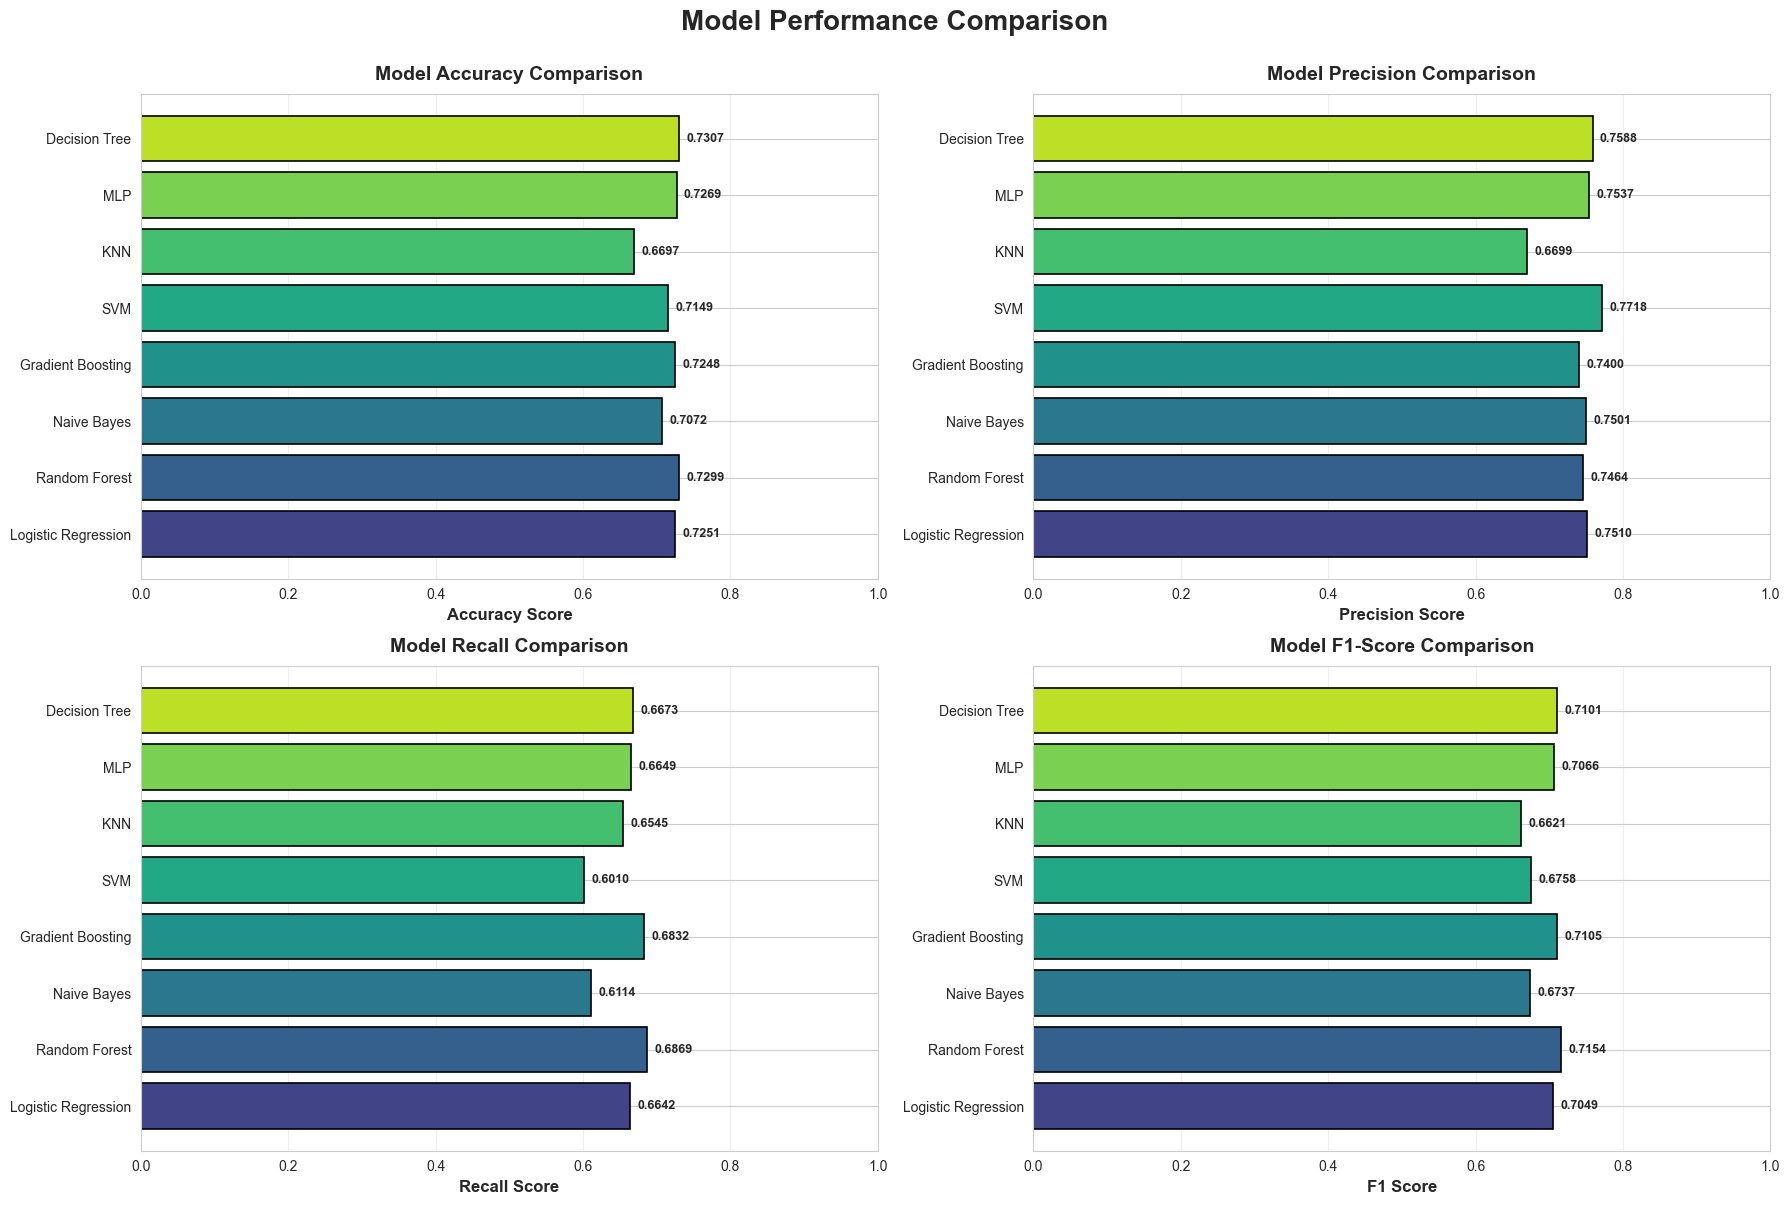


MODEL PERFORMANCE METRICS SUMMARY
Model                     Accuracy     Precision    Recall       F1-Score    
--------------------------------------------------------------------------------
Logistic Regression       0.7251       0.7510       0.6642       0.7049      
Random Forest             0.7299       0.7464       0.6869       0.7154      
Naive Bayes               0.7072       0.7501       0.6114       0.6737      
Gradient Boosting         0.7248       0.7400       0.6832       0.7105      
SVM                       0.7149       0.7718       0.6010       0.6758      
KNN                       0.6697       0.6699       0.6545       0.6621      
MLP                       0.7269       0.7537       0.6649       0.7066      
Decision Tree             0.7307       0.7588       0.6673       0.7101      


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Collect all model metrics - only include models that are defined
models_data = {}

try:
    models_data['Logistic Regression'] = matrix_logisticregression
except NameError:
    pass

try:
    models_data['Random Forest'] = matrix_randomforest
except NameError:
    pass

try:
    models_data['Naive Bayes'] = matrix_naivebayes
except NameError:
    pass

try:
    models_data['Gradient Boosting'] = matrix_gradientboosting
except NameError:
    pass

try:
    models_data['SVM'] = matrix_svm
except NameError:
    pass

try:
    models_data['KNN'] = matrix_knn
except NameError:
    pass

try:
    models_data['MLP'] = matrix_mlp
except NameError:
    pass

try:
    models_data['Decision Tree'] = matrix_decisiontree
except NameError:
    pass

if not models_data:
    print("ERROR: No model metrics found! Please run the model training cells first.")
    print("Required variables: matrix_logisticregression, matrix_randomforest, matrix_naivebayes, etc.")
else:
    print(f"Found {len(models_data)} models: {list(models_data.keys())}")
    
    # Extract metrics for each model
    model_names = list(models_data.keys())
    accuracies = [models_data[model]['accuracy'] for model in model_names]
    precisions = [models_data[model]['precision'] for model in model_names]
    recalls = [models_data[model]['recall'] for model in model_names]
    f1_scores = [models_data[model]['f1_score'] for model in model_names]

    # Create a figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Model Performance Comparison', fontsize=20, fontweight='bold', y=1.00)

    # Colors for the bars
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(model_names)))

    # 1. Accuracy Comparison
    ax1 = axes[0, 0]
    bars1 = ax1.barh(model_names, accuracies, color=colors, edgecolor='black', linewidth=1.2)
    ax1.set_xlabel('Accuracy Score', fontsize=12, fontweight='bold')
    ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold', pad=10)
    ax1.set_xlim(0, 1)
    ax1.grid(axis='x', alpha=0.3)
    # Add value labels
    for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
        ax1.text(acc + 0.01, i, f'{acc:.4f}', va='center', fontsize=9, fontweight='bold')

    # 2. Precision Comparison
    ax2 = axes[0, 1]
    bars2 = ax2.barh(model_names, precisions, color=colors, edgecolor='black', linewidth=1.2)
    ax2.set_xlabel('Precision Score', fontsize=12, fontweight='bold')
    ax2.set_title('Model Precision Comparison', fontsize=14, fontweight='bold', pad=10)
    ax2.set_xlim(0, 1)
    ax2.grid(axis='x', alpha=0.3)
    # Add value labels
    for i, (bar, prec) in enumerate(zip(bars2, precisions)):
        ax2.text(prec + 0.01, i, f'{prec:.4f}', va='center', fontsize=9, fontweight='bold')

    # 3. Recall Comparison
    ax3 = axes[1, 0]
    bars3 = ax3.barh(model_names, recalls, color=colors, edgecolor='black', linewidth=1.2)
    ax3.set_xlabel('Recall Score', fontsize=12, fontweight='bold')
    ax3.set_title('Model Recall Comparison', fontsize=14, fontweight='bold', pad=10)
    ax3.set_xlim(0, 1)
    ax3.grid(axis='x', alpha=0.3)
    # Add value labels
    for i, (bar, rec) in enumerate(zip(bars3, recalls)):
        ax3.text(rec + 0.01, i, f'{rec:.4f}', va='center', fontsize=9, fontweight='bold')

    # 4. F1-Score Comparison
    ax4 = axes[1, 1]
    bars4 = ax4.barh(model_names, f1_scores, color=colors, edgecolor='black', linewidth=1.2)
    ax4.set_xlabel('F1 Score', fontsize=12, fontweight='bold')
    ax4.set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold', pad=10)
    ax4.set_xlim(0, 1)
    ax4.grid(axis='x', alpha=0.3)
    # Add value labels
    for i, (bar, f1) in enumerate(zip(bars4, f1_scores)):
        ax4.text(f1 + 0.01, i, f'{f1:.4f}', va='center', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("\n" + "="*80)
    print("MODEL PERFORMANCE METRICS SUMMARY")
    print("="*80)
    print(f"{'Model':<25} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-"*80)
    for model in model_names:
        print(f"{model:<25} {models_data[model]['accuracy']:<12.4f} {models_data[model]['precision']:<12.4f} "
              f"{models_data[model]['recall']:<12.4f} {models_data[model]['f1_score']:<12.4f}")
    print("="*80)

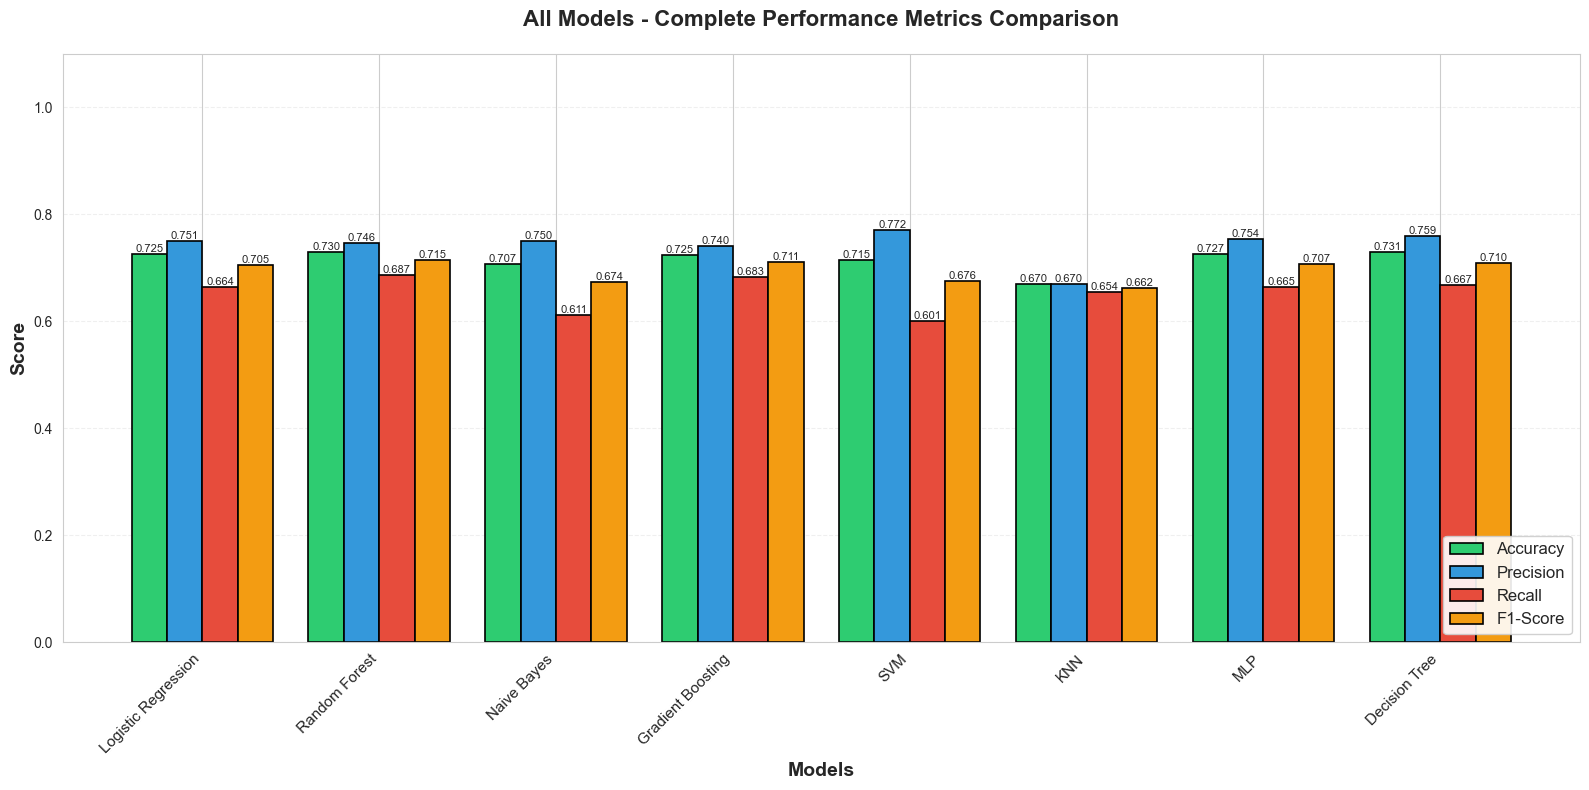


BEST PERFORMING MODELS FOR EACH METRIC
🏆 Best Accuracy:  Decision Tree             (0.7307)
🏆 Best Precision: SVM                       (0.7718)
🏆 Best Recall:    Random Forest             (0.6869)
🏆 Best F1-Score:  Random Forest             (0.7154)


In [ ]:
# Combined metrics visualization
if models_data:
    fig, ax = plt.subplots(figsize=(16, 8))

    # Set the width of bars and positions
    x = np.arange(len(model_names))
    width = 0.2

    # Create bars for each metric
    bars1 = ax.bar(x - 1.5*width, accuracies, width, label='Accuracy', color='#2ecc71', edgecolor='black', linewidth=1.2)
    bars2 = ax.bar(x - 0.5*width, precisions, width, label='Precision', color='#3498db', edgecolor='black', linewidth=1.2)
    bars3 = ax.bar(x + 0.5*width, recalls, width, label='Recall', color='#e74c3c', edgecolor='black', linewidth=1.2)
    bars4 = ax.bar(x + 1.5*width, f1_scores, width, label='F1-Score', color='#f39c12', edgecolor='black', linewidth=1.2)

    # Customize the plot
    ax.set_xlabel('Models', fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=14, fontweight='bold')
    ax.set_title('All Models - Complete Performance Metrics Comparison', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=11)
    ax.legend(loc='lower right', fontsize=12, framealpha=0.9)
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Add value labels on top of bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=8, rotation=0)

    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)
    add_value_labels(bars4)

    plt.tight_layout()
    plt.show()

    # Find the best model for each metric
    print("\n" + "="*80)
    print("BEST PERFORMING MODELS FOR EACH METRIC")
    print("="*80)
    best_accuracy_idx = np.argmax(accuracies)
    best_precision_idx = np.argmax(precisions)
    best_recall_idx = np.argmax(recalls)
    best_f1_idx = np.argmax(f1_scores)

    print(f"🏆 Best Accuracy:  {model_names[best_accuracy_idx]:<25} ({accuracies[best_accuracy_idx]:.4f})")
    print(f"🏆 Best Precision: {model_names[best_precision_idx]:<25} ({precisions[best_precision_idx]:.4f})")
    print(f"🏆 Best Recall:    {model_names[best_recall_idx]:<25} ({recalls[best_recall_idx]:.4f})")
    print(f"🏆 Best F1-Score:  {model_names[best_f1_idx]:<25} ({f1_scores[best_f1_idx]:.4f})")
    print("="*80)
else:
    print("No models available for visualization.")

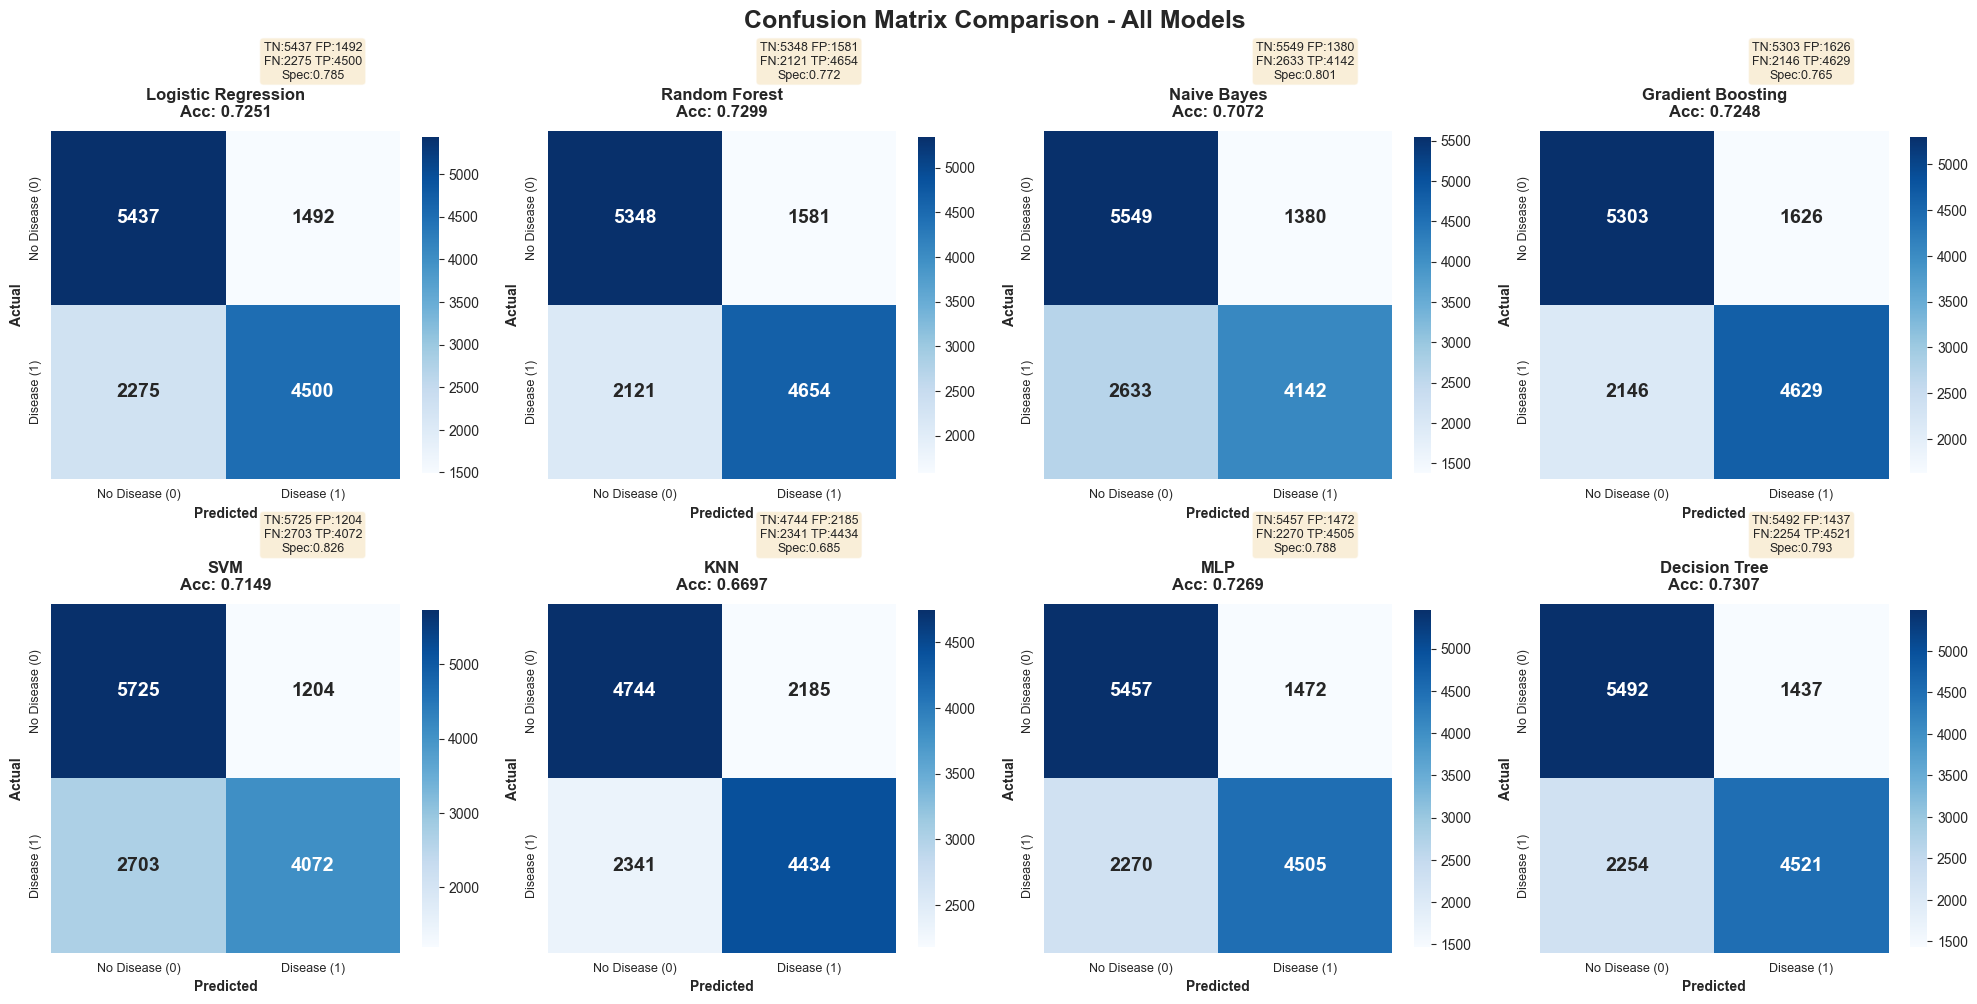


CONFUSION MATRIX ANALYSIS - ALL MODELS
Model                     TN       FP       FN       TP       Specificity  Sensitivity 
----------------------------------------------------------------------------------------------------
Logistic Regression       5437     1492     2275     4500     0.7847       0.6642      
Random Forest             5348     1581     2121     4654     0.7718       0.6869      
Naive Bayes               5549     1380     2633     4142     0.8008       0.6114      
Gradient Boosting         5303     1626     2146     4629     0.7653       0.6832      
SVM                       5725     1204     2703     4072     0.8262       0.6010      
KNN                       4744     2185     2341     4434     0.6847       0.6545      
MLP                       5457     1472     2270     4505     0.7876       0.6649      
Decision Tree             5492     1437     2254     4521     0.7926       0.6673      
Note: TN=True Negative, FP=False Positive, FN=False Negative, TP=Tr

In [ ]:
# Confusion Matrix Comparison for All Models
if models_data:
    num_models = len(models_data)
    rows = (num_models + 3) // 4  # Calculate rows needed for 4 columns
    fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
    fig.suptitle('Confusion Matrix Comparison - All Models', fontsize=18, fontweight='bold', y=0.995)

    axes = axes.flatten() if num_models > 1 else [axes]

    for idx, (model_name, model_data) in enumerate(models_data.items()):
        cm = model_data['confusion_matrix']
        
        # Create heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
                    square=True, ax=axes[idx], annot_kws={'size': 14, 'weight': 'bold'},
                    cbar_kws={'shrink': 0.8})
        
        axes[idx].set_title(f'{model_name}\nAcc: {model_data["accuracy"]:.4f}', 
                            fontsize=12, fontweight='bold', pad=10)
        axes[idx].set_xlabel('Predicted', fontsize=10, fontweight='bold')
        axes[idx].set_ylabel('Actual', fontsize=10, fontweight='bold')
        axes[idx].set_xticklabels(['No Disease (0)', 'Disease (1)'], fontsize=9)
        axes[idx].set_yticklabels(['No Disease (0)', 'Disease (1)'], fontsize=9, rotation=90, va='center')
        
        # Calculate additional metrics from confusion matrix
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        # Add text with additional info
        info_text = f'TN:{tn} FP:{fp}\nFN:{fn} TP:{tp}\nSpec:{specificity:.3f}'
        axes[idx].text(1.5, -0.3, info_text, fontsize=9, ha='center', 
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Hide empty subplots
    for idx in range(num_models, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # Print confusion matrix statistics
    print("\n" + "="*100)
    print("CONFUSION MATRIX ANALYSIS - ALL MODELS")
    print("="*100)
    print(f"{'Model':<25} {'TN':<8} {'FP':<8} {'FN':<8} {'TP':<8} {'Specificity':<12} {'Sensitivity':<12}")
    print("-"*100)

    for model_name, model_data in models_data.items():
        cm = model_data['confusion_matrix']
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Same as recall
        
        print(f"{model_name:<25} {tn:<8} {fp:<8} {fn:<8} {tp:<8} {specificity:<12.4f} {sensitivity:<12.4f}")

    print("="*100)
    print("Note: TN=True Negative, FP=False Positive, FN=False Negative, TP=True Positive")
    print("      Specificity = TN/(TN+FP), Sensitivity = TP/(TP+FN) = Recall")
    print("="*100)
else:
    print("No models available for confusion matrix visualization.")

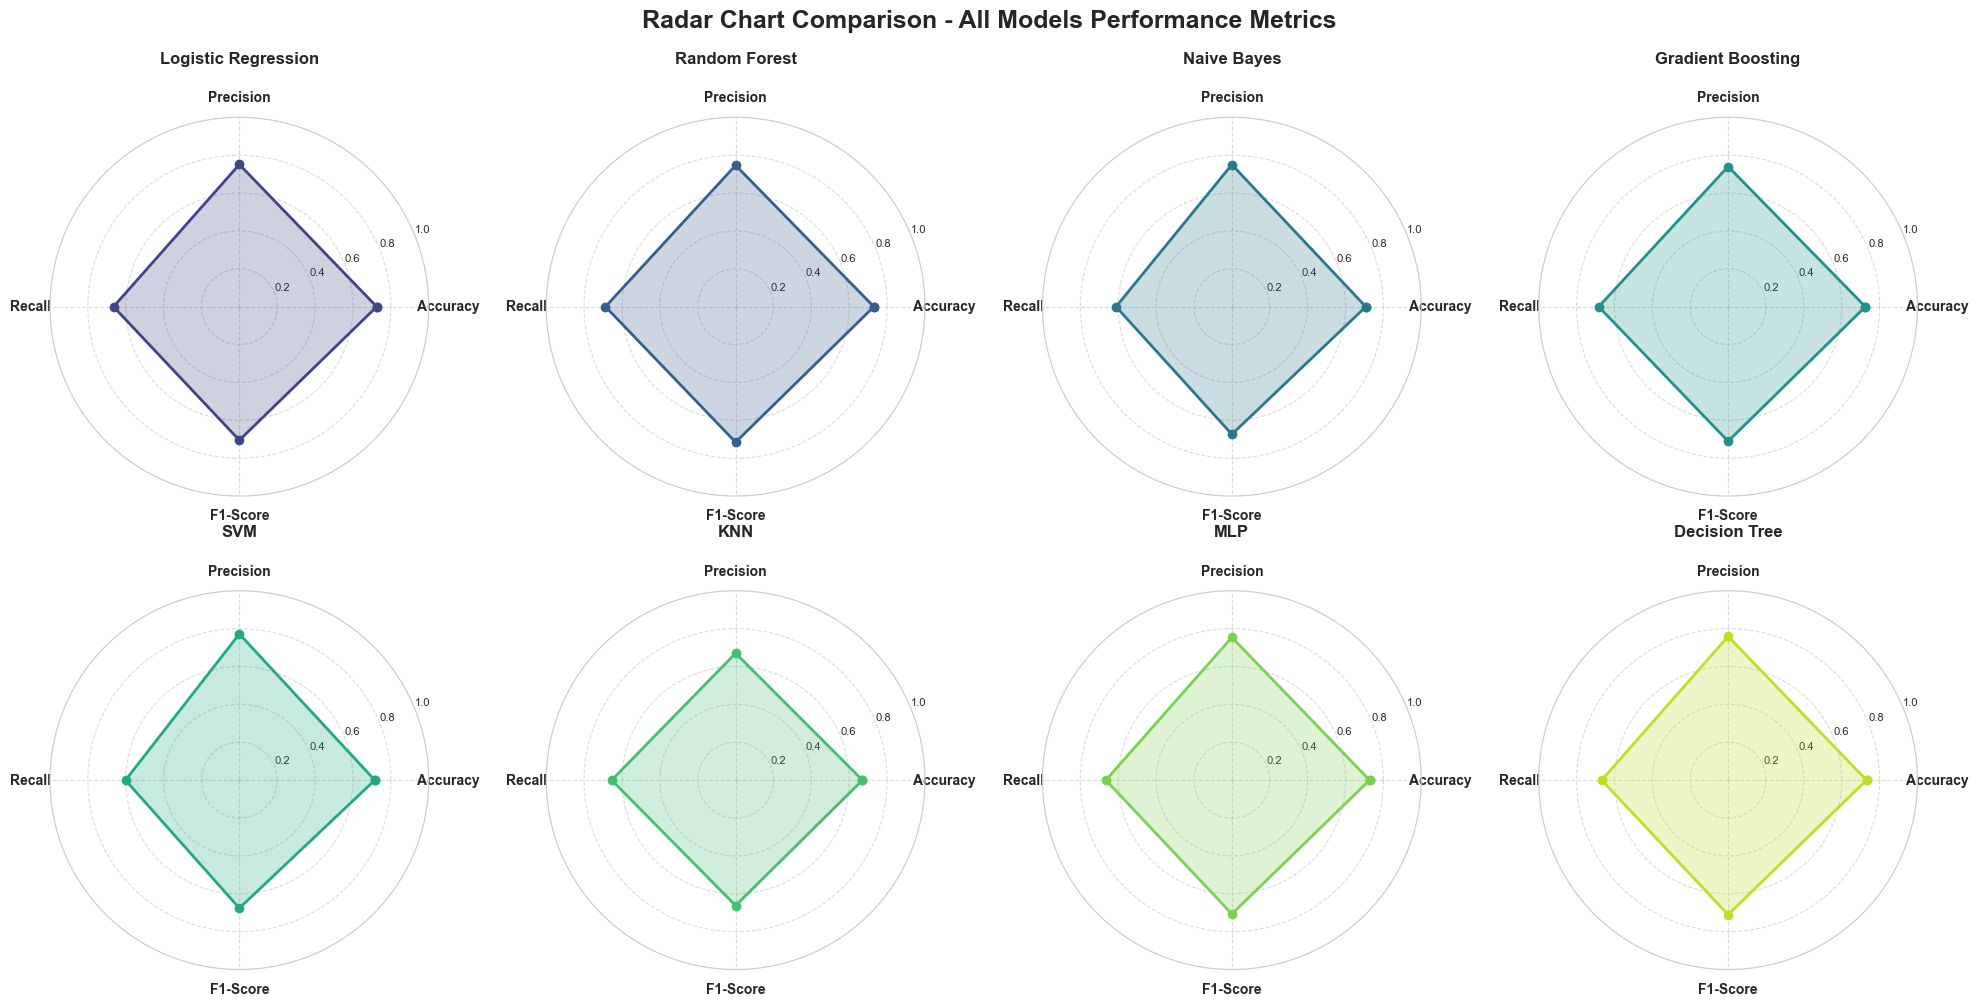

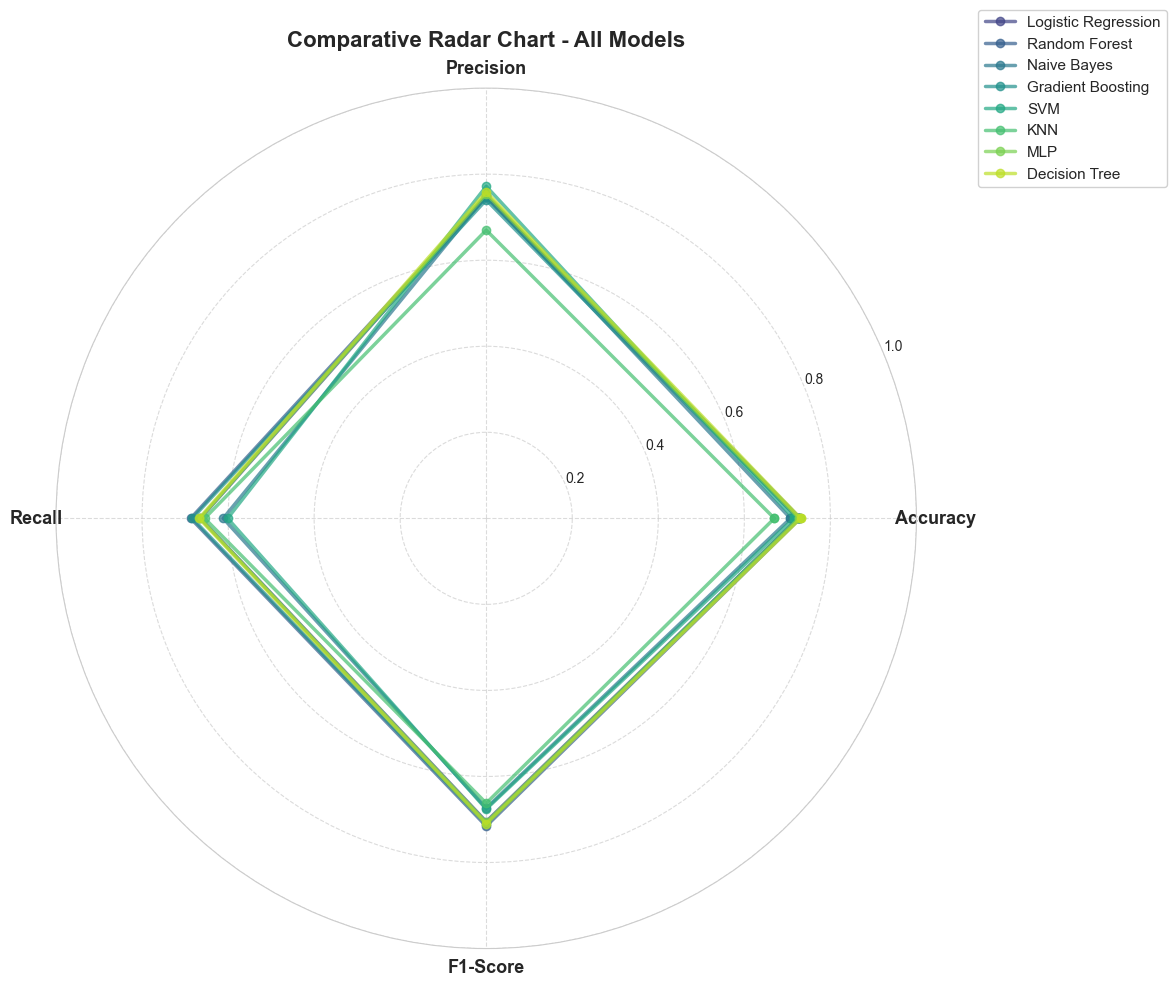

In [ ]:
# Radar Chart for Model Comparison
from math import pi

# Prepare data for radar chart
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
N = len(categories)

# Create figure with multiple subplots for radar charts
fig, axes = plt.subplots(2, 4, figsize=(20, 10), subplot_kw=dict(projection='polar'))
fig.suptitle('Radar Chart Comparison - All Models Performance Metrics', fontsize=18, fontweight='bold', y=0.995)

axes = axes.flatten()

# Compute angle for each axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot for each model
for idx, (model_name, model_data) in enumerate(models_data.items()):
    values = [
        model_data['accuracy'],
        model_data['precision'],
        model_data['recall'],
        model_data['f1_score']
    ]
    values += values[:1]
    
    ax = axes[idx]
    
    # Plot data
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[idx])
    ax.fill(angles, values, alpha=0.25, color=colors[idx])
    
    # Fix axis to go in the right order
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=10, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=8)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add title
    ax.set_title(model_name, size=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Create a single comparative radar chart with all models
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))
ax.set_title('Comparative Radar Chart - All Models', size=16, fontweight='bold', pad=30)

for idx, (model_name, model_data) in enumerate(models_data.items()):
    values = [
        model_data['accuracy'],
        model_data['precision'],
        model_data['recall'],
        model_data['f1_score']
    ]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2.5, label=model_name, color=colors[idx], alpha=0.7)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=13, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=10)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()



# ROC, Precision - Recall curves


Generating visualizations...
Saved confusion_matrix_heatmap.png
Saved roc_curve.png


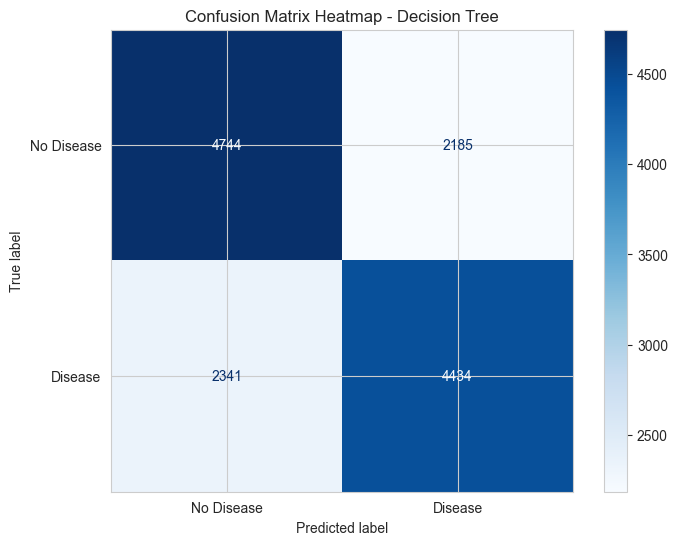

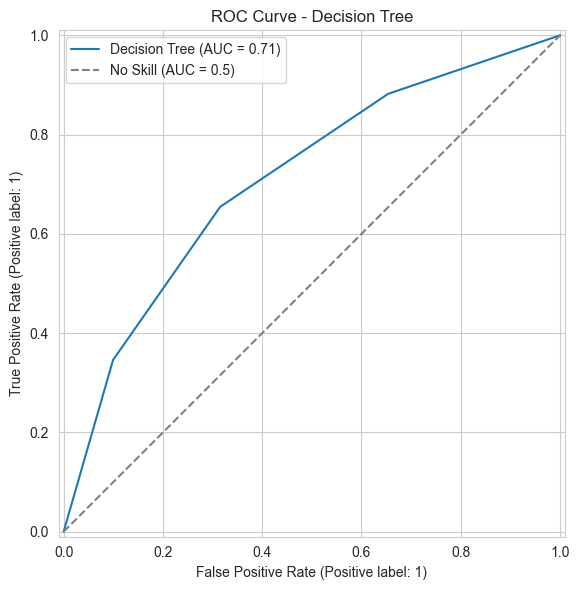

All visualizations generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    RocCurveDisplay,
    ConfusionMatrixDisplay
)

# --- Ensure these imports are also present ---
# (They were in your original file but are needed here too)
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("Generating visualizations...")

# --- 1. Confusion Matrix Heatmap ---
# We can use the from_estimator method, which is the cleanest way.
# It takes the trained model and test data, makes predictions, 
# and plots the matrix all in one step.

fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
disp_cm = ConfusionMatrixDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    display_labels=['No Disease', 'Disease'], # From your classification report
    cmap='Blues',
    ax=ax_cm
)
ax_cm.set_title('Confusion Matrix Heatmap - Decision Tree')
plt.savefig('confusion_matrix_heatmap.png')
print("Saved confusion_matrix_heatmap.png")


# --- 2. ROC Curve ---
# Create a single subplot for ROC curve only
fig_roc, ax_roc = plt.subplots(figsize=(8, 6))

# --- Plot ROC Curve ---
RocCurveDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    name='Decision Tree',
    ax=ax_roc
)
# Add a "no-skill" (random guess) line
ax_roc.plot([0, 1], [0, 1], linestyle='--', color='grey', label='No Skill (AUC = 0.5)')
ax_roc.set_title('ROC Curve - Decision Tree')
ax_roc.legend()

# Save the ROC curve figure
plt.tight_layout()
plt.savefig('roc_curve.png')
print("Saved roc_curve.png")

# Finally, display all plots
plt.show()

print("All visualizations generated.")


Generating visualizations for Logistic Regression...
Saved confusion_matrix_logistic.png
Saved roc_curve_logistic.png


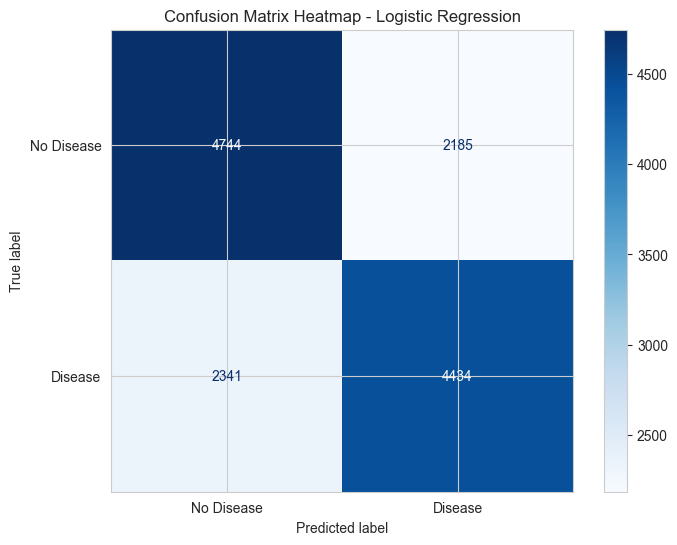

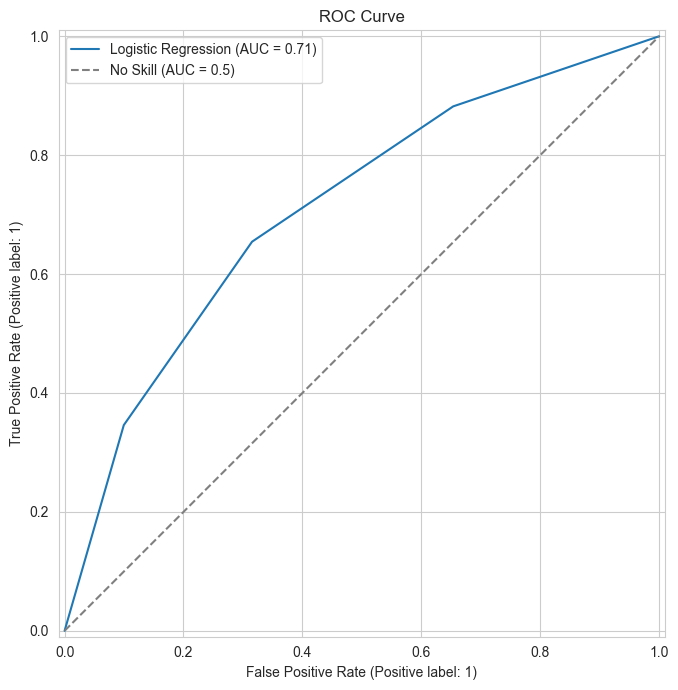

All visualizations generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    RocCurveDisplay,
    ConfusionMatrixDisplay
)

# --- Ensure these imports are also present ---
# (They were in your original file but are needed here too)
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("Generating visualizations for Logistic Regression...")

# --- 1. Confusion Matrix Heatmap ---
# We use from_estimator, which takes the trained model and test data,
# makes predictions, and plots the matrix in one step.

fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
disp_cm = ConfusionMatrixDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    display_labels=['No Disease', 'Disease'], # From your classification report
    cmap='Blues',
    ax=ax_cm
)
ax_cm.set_title('Confusion Matrix Heatmap - Logistic Regression')
plt.savefig('confusion_matrix_logistic.png')
print("Saved confusion_matrix_logistic.png")


# --- 2. ROC Curve ---
fig_roc, ax_roc = plt.subplots(figsize=(8, 7))
RocCurveDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    name='Logistic Regression',
    ax=ax_roc
)
# Add a "no-skill" (random guess) line
ax_roc.plot([0, 1], [0, 1], linestyle='--', color='grey', label='No Skill (AUC = 0.5)')
ax_roc.set_title('ROC Curve')
ax_roc.legend()

# Save the figure
plt.tight_layout()
plt.savefig('roc_curve_logistic.png')
print("Saved roc_curve_logistic.png")

# Finally, display all plots
plt.show()

print("All visualizations generated.")

Generating visualizations for Random Forest...
Saved confusion_matrix_random_forest.png
Saved roc_and_pr_curves_random_forest.png


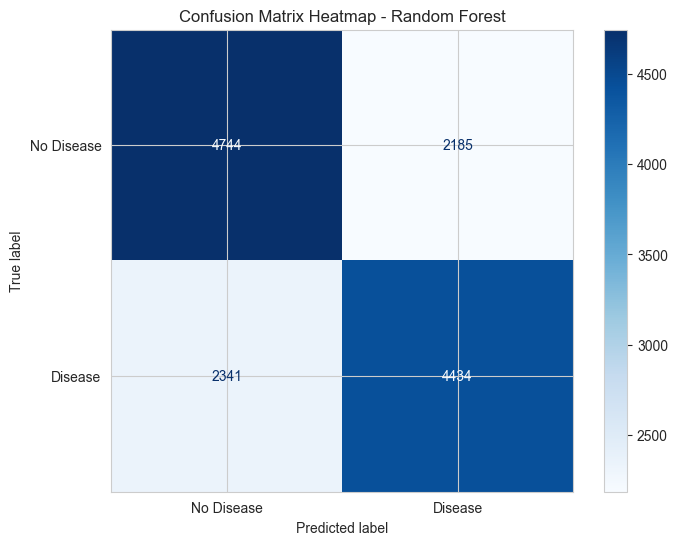

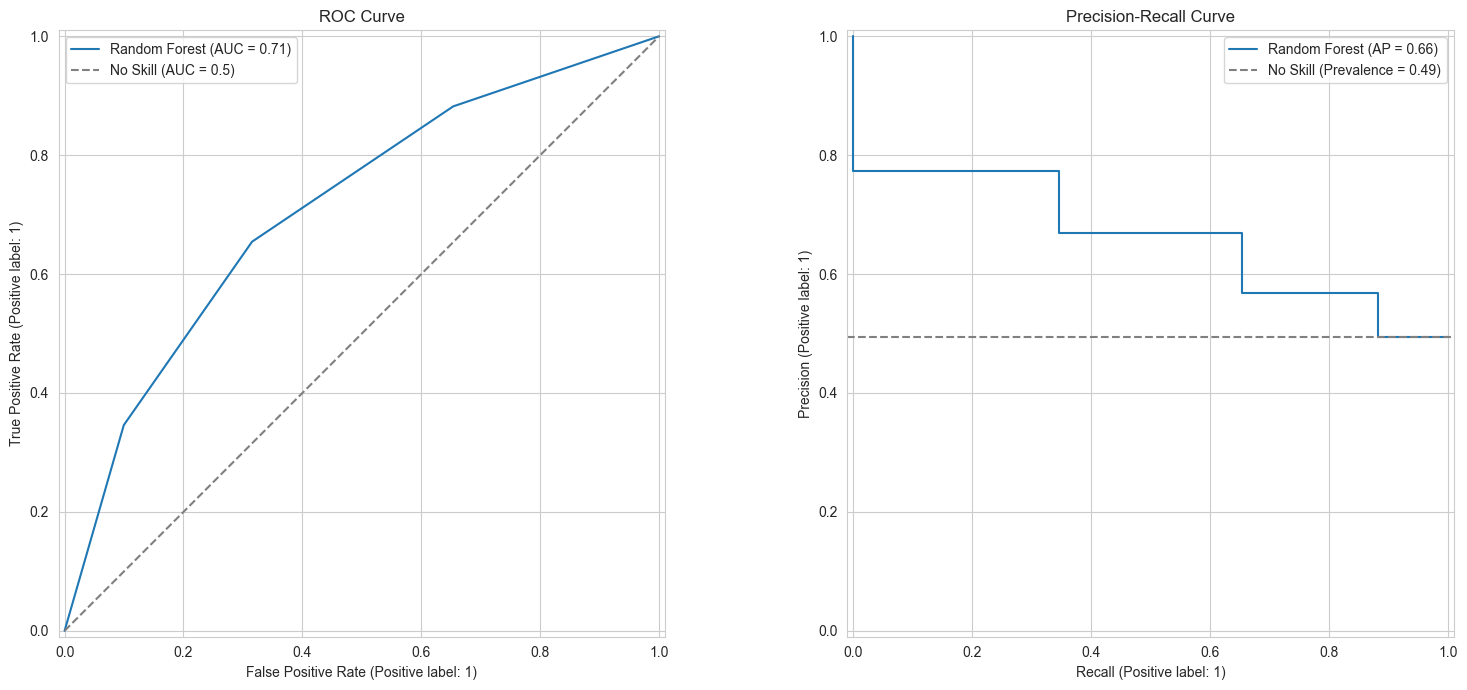

All visualizations generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)

# --- Ensure these imports are also present ---
# (They were in your original file but are needed here too)
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("Generating visualizations for Random Forest...")

# --- 1. Confusion Matrix Heatmap ---
# We use from_estimator, which takes the trained model and test data,
# makes predictions, and plots the matrix in one step.

fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
disp_cm = ConfusionMatrixDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    display_labels=['No Disease', 'Disease'], # From your classification report
    cmap='Blues',
    ax=ax_cm
)
ax_cm.set_title('Confusion Matrix Heatmap - Random Forest')
plt.savefig('confusion_matrix_random_forest.png')
print("Saved confusion_matrix_random_forest.png")


# --- 2. ROC and Precision-Recall Curves (Side-by-Side) ---
# It's often best to view these two plots together.

# Create a figure with two subplots
fig_curves, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(16, 7))

# --- Plot 2a: ROC Curve ---
RocCurveDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    name='Random Forest',
    ax=ax_roc
)
# Add a "no-skill" (random guess) line
ax_roc.plot([0, 1], [0, 1], linestyle='--', color='grey', label='No Skill (AUC = 0.5)')
ax_roc.set_title('ROC Curve')
ax_roc.legend()

# --- Plot 2b: Precision-Recall Curve ---
PrecisionRecallDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    name='Random Forest',
    ax=ax_pr
)
# Add a "no-skill" line (baseline is the prevalence of the positive class)
no_skill = clf.y_test.mean()
ax_pr.axhline(y=no_skill, linestyle='--', color='grey', 
              label=f'No Skill (Prevalence = {no_skill:.2f})')
ax_pr.set_title('Precision-Recall Curve')
ax_pr.legend()

# Save the combined figure
plt.tight_layout()
plt.savefig('roc_and_pr_curves_random_forest.png')
print("Saved roc_and_pr_curves_random_forest.png")

# Finally, display all plots
plt.show()

print("All visualizations generated.")

Generating visualizations for Naive Bayes...
Saved confusion_matrix_naive_bayes.png
Saved roc_and_pr_curves_naive_bayes.png


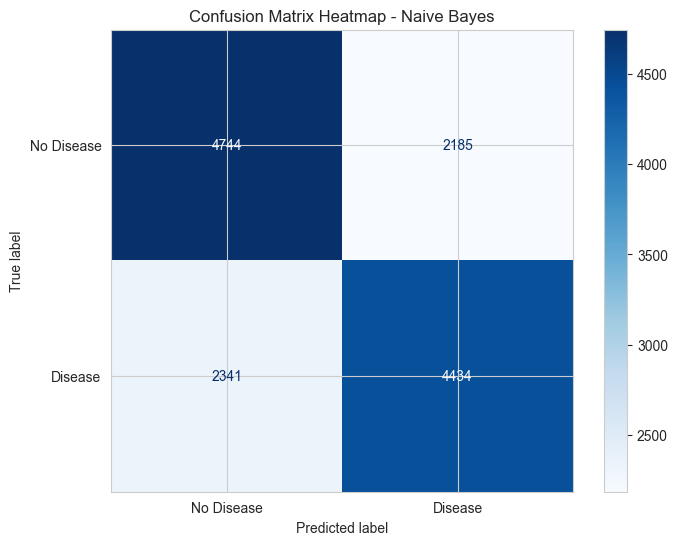

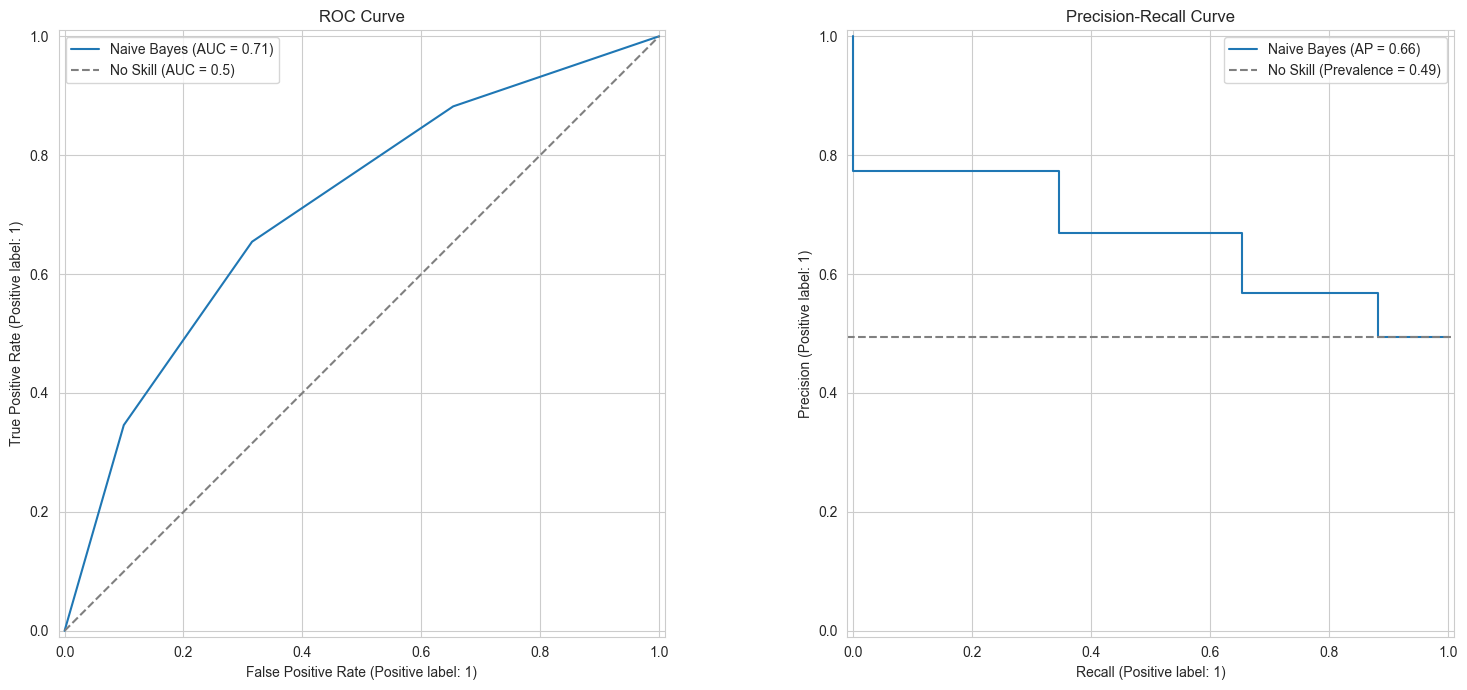

All visualizations generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)

# --- Ensure these imports are also present ---
# (They were in your original file but are needed here too)
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("Generating visualizations for Naive Bayes...")

# --- 1. Confusion Matrix Heatmap ---
# We use from_estimator, which takes the trained model and test data,
# makes predictions, and plots the matrix in one step.

fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
disp_cm = ConfusionMatrixDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    display_labels=['No Disease', 'Disease'], # From your classification report
    cmap='Blues',
    ax=ax_cm
)
ax_cm.set_title('Confusion Matrix Heatmap - Naive Bayes')
plt.savefig('confusion_matrix_naive_bayes.png')
print("Saved confusion_matrix_naive_bayes.png")


# --- 2. ROC and Precision-Recall Curves (Side-by-Side) ---
# It's often best to view these two plots together.

# Create a figure with two subplots
fig_curves, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(16, 7))

# --- Plot 2a: ROC Curve ---
RocCurveDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    name='Naive Bayes',
    ax=ax_roc
)
# Add a "no-skill" (random guess) line
ax_roc.plot([0, 1], [0, 1], linestyle='--', color='grey', label='No Skill (AUC = 0.5)')
ax_roc.set_title('ROC Curve')
ax_roc.legend()

# --- Plot 2b: Precision-Recall Curve ---
PrecisionRecallDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    name='Naive Bayes',
    ax=ax_pr
)
# Add a "no-skill" line (baseline is the prevalence of the positive class)
no_skill = clf.y_test.mean()
ax_pr.axhline(y=no_skill, linestyle='--', color='grey', 
              label=f'No Skill (Prevalence = {no_skill:.2f})')
ax_pr.set_title('Precision-Recall Curve')
ax_pr.legend()

# Save the combined figure
plt.tight_layout()
plt.savefig('roc_and_pr_curves_naive_bayes.png')
print("Saved roc_and_pr_curves_naive_bayes.png")

# Finally, display all plots
plt.show()

print("All visualizations generated.")

Generating visualizations for Gradient Boosting...
Saved confusion_matrix_gradient_boosting.png
Saved roc_and_pr_curves_gradient_boosting.png


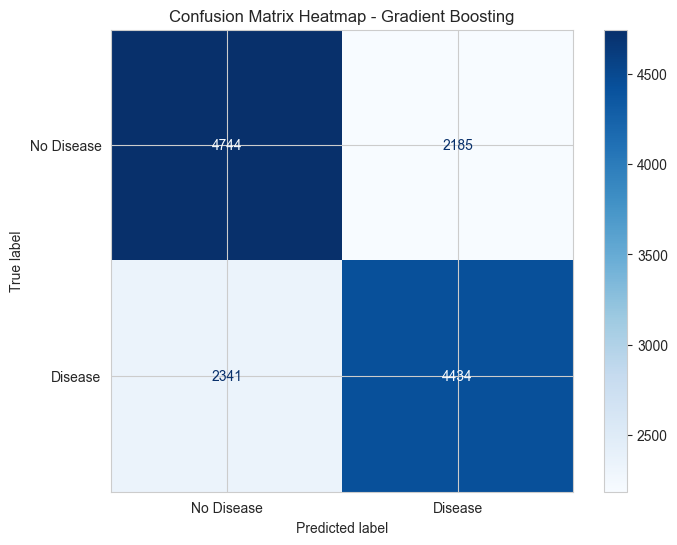

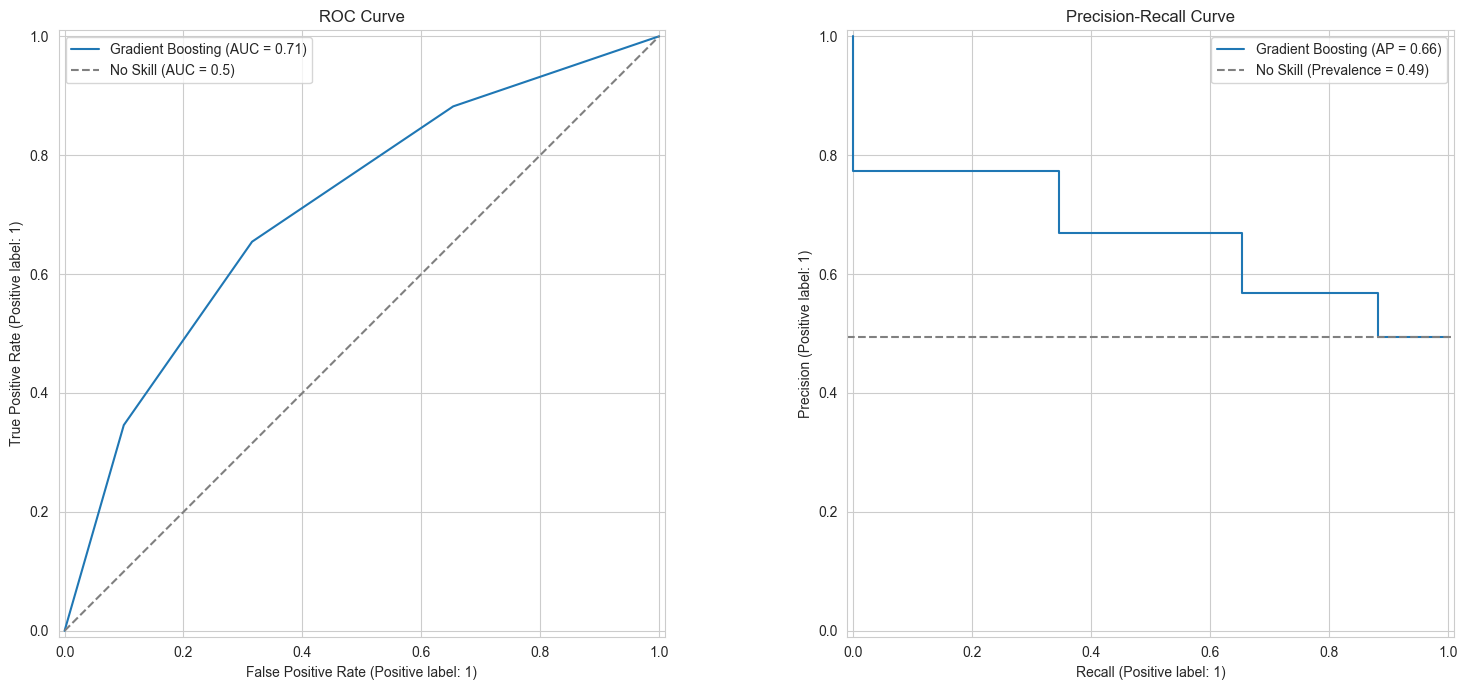

All visualizations generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)

# --- Ensure these imports are also present ---
# (They were in your original file but are needed here too)
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("Generating visualizations for Gradient Boosting...")

# --- 1. Confusion Matrix Heatmap ---
# We use from_estimator, which takes the trained model and test data,
# makes predictions, and plots the matrix in one step.

fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
disp_cm = ConfusionMatrixDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    display_labels=['No Disease', 'Disease'], # From your classification report
    cmap='Blues',
    ax=ax_cm
)
ax_cm.set_title('Confusion Matrix Heatmap - Gradient Boosting')
plt.savefig('confusion_matrix_gradient_boosting.png')
print("Saved confusion_matrix_gradient_boosting.png")


# --- 2. ROC and Precision-Recall Curves (Side-by-Side) ---
# It's often best to view these two plots together.

# Create a figure with two subplots
fig_curves, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(16, 7))

# --- Plot 2a: ROC Curve ---
RocCurveDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    name='Gradient Boosting',
    ax=ax_roc
)
# Add a "no-skill" (random guess) line
ax_roc.plot([0, 1], [0, 1], linestyle='--', color='grey', label='No Skill (AUC = 0.5)')
ax_roc.set_title('ROC Curve')
ax_roc.legend()

# --- Plot 2b: Precision-Recall Curve ---
PrecisionRecallDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    name='Gradient Boosting',
    ax=ax_pr
)
# Add a "no-skill" line (baseline is the prevalence of the positive class)
no_skill = clf.y_test.mean()
ax_pr.axhline(y=no_skill, linestyle='--', color='grey', 
              label=f'No Skill (Prevalence = {no_skill:.2f})')
ax_pr.set_title('Precision-Recall Curve')
ax_pr.legend()

# Save the combined figure
plt.tight_layout()
plt.savefig('roc_and_pr_curves_gradient_boosting.png')
print("Saved roc_and_pr_curves_gradient_boosting.png")

# Finally, display all plots
plt.show()

print("All visualizations generated.")

Generating visualizations for Support Vector Machine (SVM)...
Saved confusion_matrix_svm.png
Saved roc_and_pr_curves_svm.png


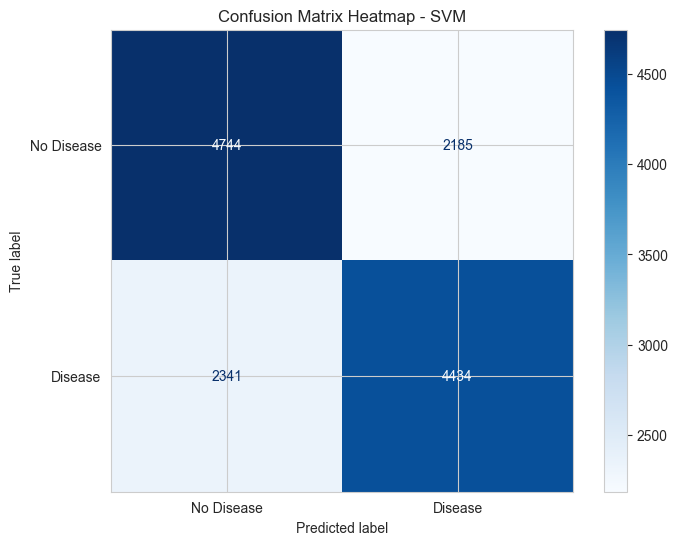

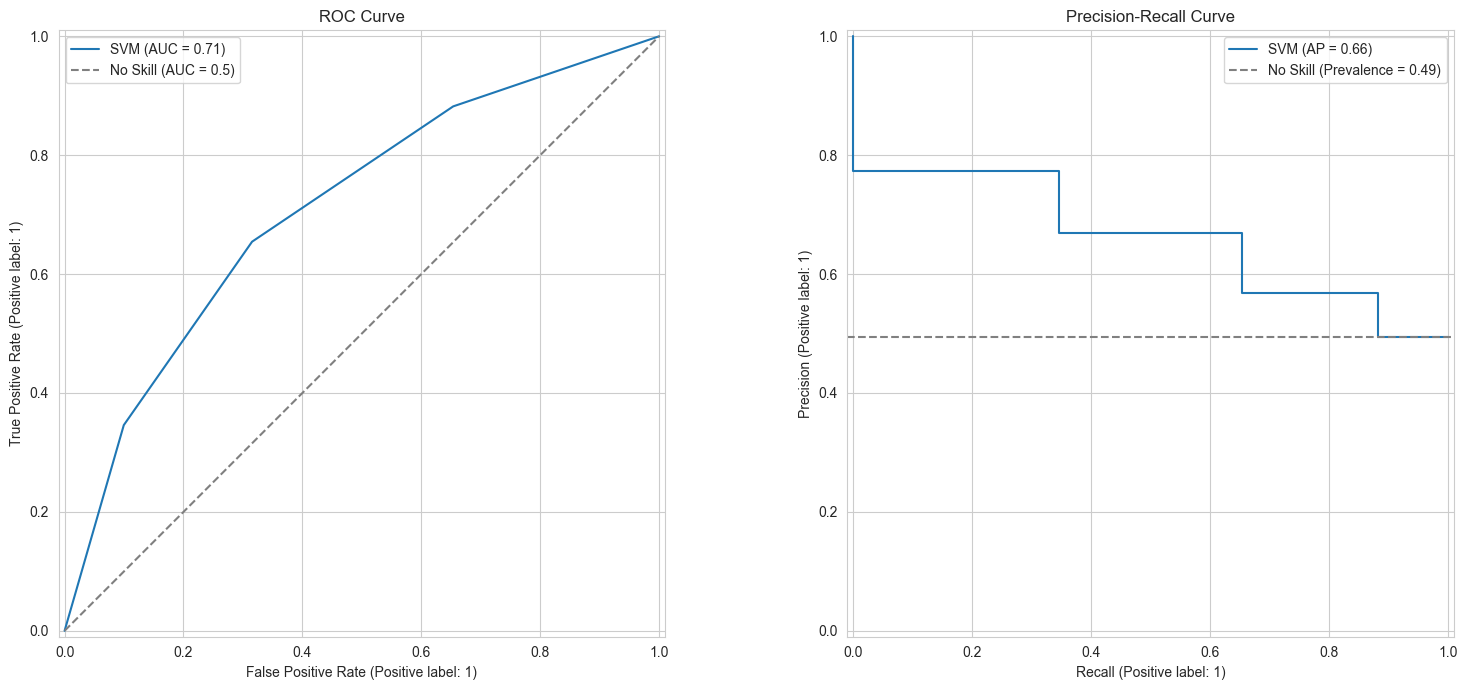

All visualizations generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)

# --- Ensure these imports are also present ---
# (They were in your original file but are needed here too)
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("Generating visualizations for Support Vector Machine (SVM)...")

# --- 1. Confusion Matrix Heatmap ---
# We use from_estimator, which takes the trained model and test data,
# makes predictions, and plots the matrix in one step.

fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
disp_cm = ConfusionMatrixDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    display_labels=['No Disease', 'Disease'], # From your classification report
    cmap='Blues',
    ax=ax_cm
)
ax_cm.set_title('Confusion Matrix Heatmap - SVM')
plt.savefig('confusion_matrix_svm.png')
print("Saved confusion_matrix_svm.png")


# --- 2. ROC and Precision-Recall Curves (Side-by-Side) ---
# It's often best to view these two plots together.

# Create a figure with two subplots
fig_curves, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(16, 7))

# --- Plot 2a: ROC Curve ---
RocCurveDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    name='SVM',
    ax=ax_roc
)
# Add a "no-skill" (random guess) line
ax_roc.plot([0, 1], [0, 1], linestyle='--', color='grey', label='No Skill (AUC = 0.5)')
ax_roc.set_title('ROC Curve')
ax_roc.legend()

# --- Plot 2b: Precision-Recall Curve ---
PrecisionRecallDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    name='SVM',
    ax=ax_pr
)
# Add a "no-skill" line (baseline is the prevalence of the positive class)
no_skill = clf.y_test.mean()
ax_pr.axhline(y=no_skill, linestyle='--', color='grey', 
              label=f'No Skill (Prevalence = {no_skill:.2f})')
ax_pr.set_title('Precision-Recall Curve')
ax_pr.legend()

# Save the combined figure
plt.tight_layout()
plt.savefig('roc_and_pr_curves_svm.png')
print("Saved roc_and_pr_curves_svm.png")

# Finally, display all plots
plt.show()

print("All visualizations generated.")

Generating visualizations for K-Nearest Neighbors (KNN)...
Saved confusion_matrix_knn.png
Saved roc_and_pr_curves_knn.png


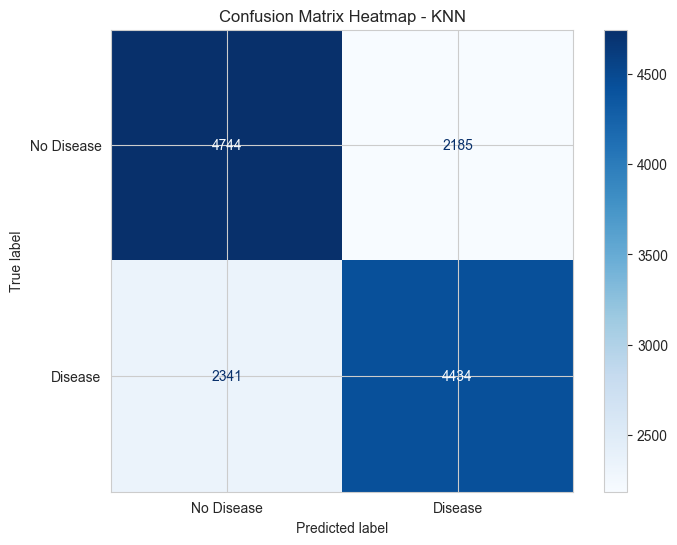

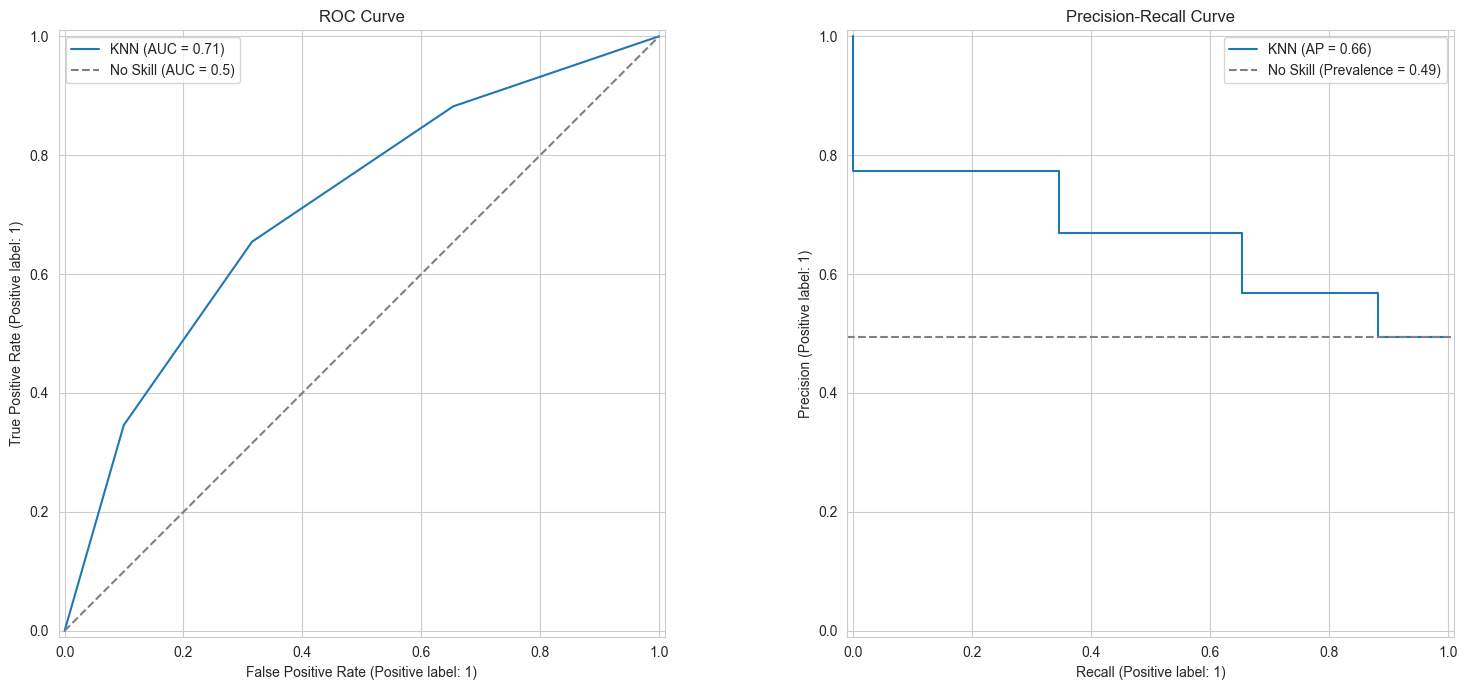

All visualizations generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)

# --- Ensure these imports are also present ---
# (They were in your original file but are needed here too)
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("Generating visualizations for K-Nearest Neighbors (KNN)...")

# --- 1. Confusion Matrix Heatmap ---
# We use from_estimator, which takes the trained model and test data,
# makes predictions, and plots the matrix in one step.

fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
disp_cm = ConfusionMatrixDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    display_labels=['No Disease', 'Disease'], # From your classification report
    cmap='Blues',
    ax=ax_cm
)
ax_cm.set_title('Confusion Matrix Heatmap - KNN')
plt.savefig('confusion_matrix_knn.png')
print("Saved confusion_matrix_knn.png")


# --- 2. ROC and Precision-Recall Curves (Side-by-Side) ---
# It's often best to view these two plots together.

# Create a figure with two subplots
fig_curves, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(16, 7))

# --- Plot 2a: ROC Curve ---
RocCurveDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    name='KNN',
    ax=ax_roc
)
# Add a "no-skill" (random guess) line
ax_roc.plot([0, 1], [0, 1], linestyle='--', color='grey', label='No Skill (AUC = 0.5)')
ax_roc.set_title('ROC Curve')
ax_roc.legend()

# --- Plot 2b: Precision-Recall Curve ---
PrecisionRecallDisplay.from_estimator(
    clf.model,
    clf.X_test,
    clf.y_test,
    name='KNN',
    ax=ax_pr
)
# Add a "no-skill" line (baseline is the prevalence of the positive class)
no_skill = clf.y_test.mean()
ax_pr.axhline(y=no_skill, linestyle='--', color='grey', 
              label=f'No Skill (Prevalence = {no_skill:.2f})')
ax_pr.set_title('Precision-Recall Curve')
ax_pr.legend()

# Save the combined figure
plt.tight_layout()
plt.savefig('roc_and_pr_curves_knn.png')
print("Saved roc_and_pr_curves_knn.png")

# Finally, display all plots
plt.show()

print("All visualizations generated.")

Generating visualizations for MLP...
Saved confusion_matrix_mlp.png
Saved roc_and_pr_curves_mlp.png


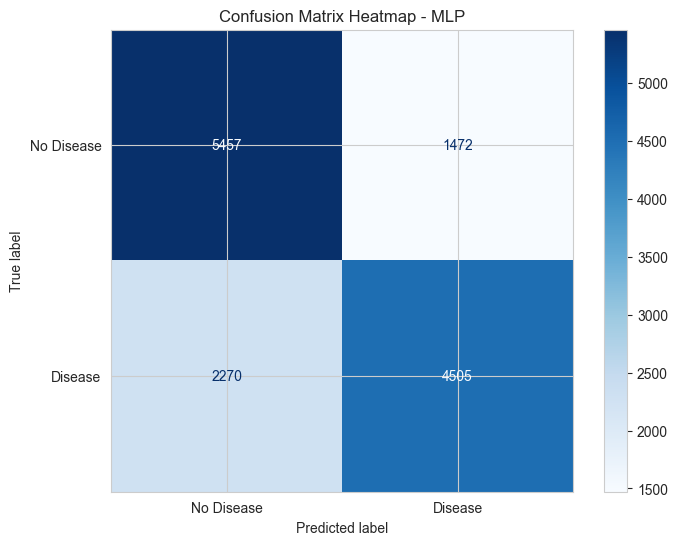

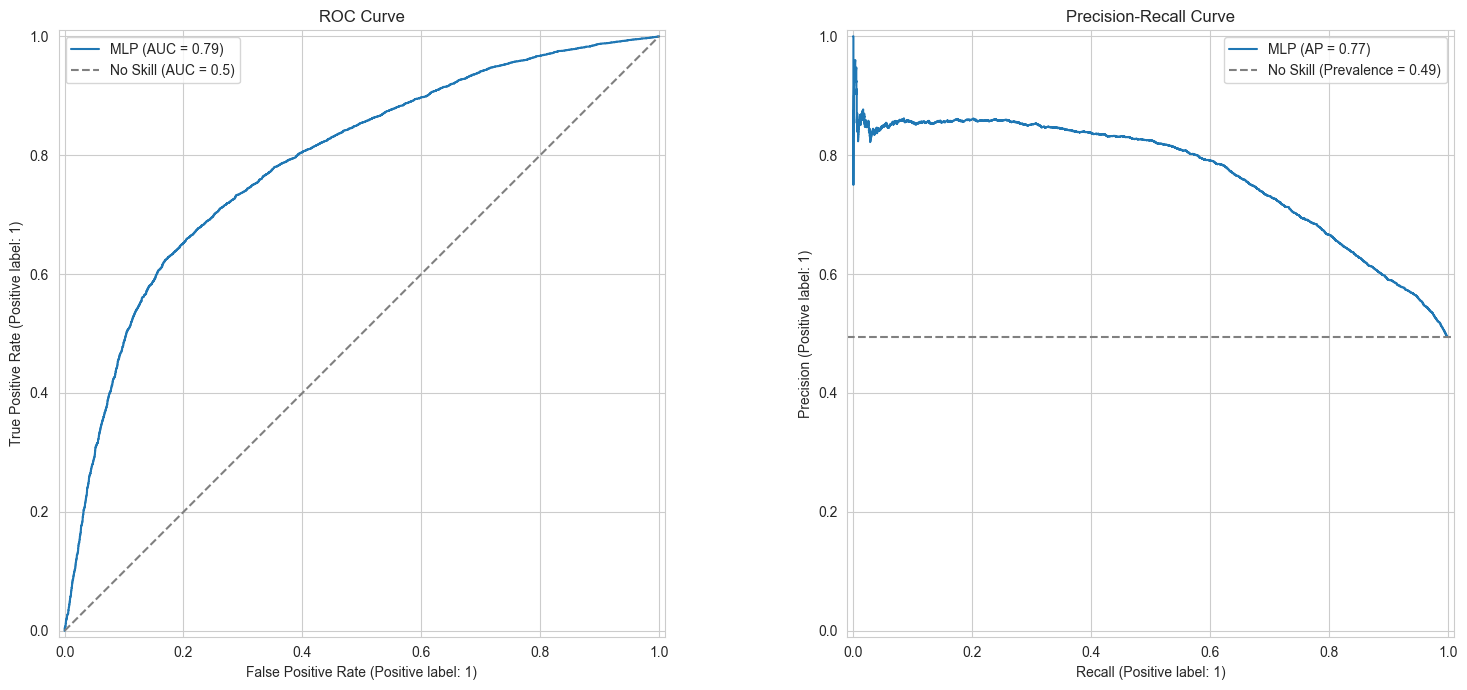

All visualizations generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)
import torch
import torch.nn.functional as F

# --- Ensure these imports are also present ---
# (They were in your original file but are needed here too)
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("Generating visualizations for MLP...")

# --- Helper Function to get Predictions and Probabilities ---
def get_mlp_outputs(clf_obj):
    """
    Gets final predictions and positive class probabilities from the trained PyTorch model.
    """
    # Set model to evaluation mode (disables dropout, etc.)
    clf_obj.model.eval() 
    
    # Prepare test data tensor
    X_test_tensor = torch.FloatTensor(clf_obj.X_test.values).to(clf_obj.device)
    
    with torch.no_grad(): # Disable gradient calculation
        # Get raw model outputs (logits)
        outputs = clf_obj.model(X_test_tensor)
        
        # 1. Get Probabilities
        # Apply softmax to convert logits to probabilities
        probabilities = F.softmax(outputs, dim=1)
        # Get the probability for the positive class (class 1)
        y_probs = probabilities[:, 1].cpu().numpy()
        
        # 2. Get Final Predictions
        # Find the class with the highest logit/probability
        _, y_preds = torch.max(outputs.data, 1)
        y_preds = y_preds.cpu().numpy()
        
    return y_preds, y_probs

# --- Get True Labels, Predicted Labels, and Predicted Probabilities ---
try:
    y_true = mlp_clf.y_test
    y_pred, y_prob = get_mlp_outputs(mlp_clf)

    # --- 1. Confusion Matrix Heatmap ---
    fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
    disp_cm = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=['No Disease', 'Disease'],
        cmap='Blues',
        ax=ax_cm
    )
    ax_cm.set_title('Confusion Matrix Heatmap - MLP')
    plt.savefig('confusion_matrix_mlp.png')
    print("Saved confusion_matrix_mlp.png")


    # --- 2. ROC and Precision-Recall Curves (Side-by-Side) ---
    fig_curves, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(16, 7))

    # --- Plot 2a: ROC Curve ---
    RocCurveDisplay.from_predictions(
        y_true,
        y_prob,
        name='MLP',
        ax=ax_roc
    )
    ax_roc.plot([0, 1], [0, 1], linestyle='--', color='grey', label='No Skill (AUC = 0.5)')
    ax_roc.set_title('ROC Curve')
    ax_roc.legend()

    # --- Plot 2b: Precision-Recall Curve ---
    PrecisionRecallDisplay.from_predictions(
        y_true,
        y_prob,
        name='MLP',
        ax=ax_pr
    )
    no_skill = np.mean(y_true) # Use numpy mean on y_true pandas Series
    ax_pr.axhline(y=no_skill, linestyle='--', color='grey', 
                  label=f'No Skill (Prevalence = {no_skill:.2f})')
    ax_pr.set_title('Precision-Recall Curve')
    ax_pr.legend()

    # Save the combined figure
    plt.tight_layout()
    plt.savefig('roc_and_pr_curves_mlp.png')
    print("Saved roc_and_pr_curves_mlp.png")

    # Finally, display all plots
    plt.show()

    print("All visualizations generated.")

except NameError:
    print("Error: The 'mlp_clf' object was not found.")
    print("Please make sure you have run the MLP training script first.")
except Exception as e:
    print(f"An error occurred: {e}")